In [96]:
!pip install pandas sqlalchemy psycopg2 matplotlib pymongo


In [97]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import json
from pymongo import MongoClient

# Define the path to the config file
config_path = 'config/config.json'

# Load configuration from file
with open(config_path) as config_file:
    config = json.load(config_file)

# PostgreSQL configuration
pg_user = config['pg_user']
pg_password = config['pg_password']
pg_host = config['pg_host']
pg_port = config['pg_port']
pg_db_name = config['pg_db_name']

# MongoDB configuration
mongo_host = config['mongo_host']
mongo_port = config['mongo_port']
mongo_db_name = config['mongo_db_name']

# Create PostgreSQL connection
pg_engine = create_engine(f'postgresql://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_db_name}')

# Create MongoDB connection with error handling
try:
    mongo_client = MongoClient(mongo_host, mongo_port)
    mongo_db = mongo_client[mongo_db_name]

    # Check if the collection exists
    collections = mongo_db.list_collection_names()
    if "appearances" in collections:
        print("The 'Appearances' collection exists.")
    else:
        print("The 'Appearances' collection does not exist.")

    # Check the count of documents in the collection
    mongo_collection = mongo_db["appearances"]
    count = mongo_collection.count_documents({})
    print(f"The 'Appearances' collection has {count} documents.")

    # Query to test the MongoDB connection
    mongo_query_result = mongo_collection.find_one()
    if mongo_query_result:
        print("Sample document from 'Appearances':")
        print(mongo_query_result)
    else:
        print("The 'Appearances' collection is empty.")
except Exception as e:
    print(f"Error connecting to MongoDB: {e}")

# Query to test the PostgreSQL connection with error handling
try:
    pg_query = "SELECT version();"
    pg_df = pd.read_sql_query(pg_query, pg_engine)
    print("Successfully connected to PostgreSQL. Version info:")
    print(pg_df)
except Exception as e:
    print(f"Error connecting to PostgreSQL: {e}")


The 'Appearances' collection exists.
The 'Appearances' collection has 1507351 documents.
Sample document from 'Appearances':
{'_id': ObjectId('663ba07ebc348c252ac23ef8'), 'appearance_id': '2231978_38004', 'game_id': 2231978, 'player_id': 38004, 'player_club_id': 853, 'player_current_club_id': 235, 'date': datetime.datetime(2012, 7, 3, 0, 0), 'player_name': 'Aurélien Joachim', 'competition_id': 'CLQ', 'yellow_cards': 0, 'red_cards': 0, 'goals': 2, 'assists': 0, 'minutes_played': 90}
Successfully connected to PostgreSQL. Version info:
                                             version
0  PostgreSQL 16.1 on x86_64-apple-darwin20.6.0, ...


# Players Analysis Functions

# Analysis of a Player Performance

## Total Goals and Assists by Season

<p style="font-size:20px; color:green;">Important Note: Data includes all competitions.</p>



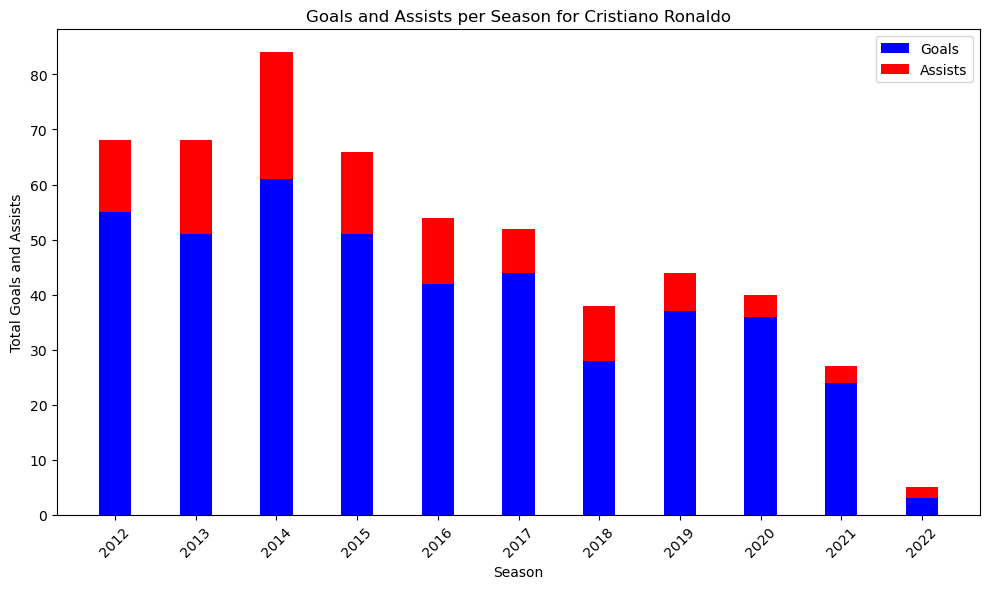

In [98]:
def plot_goals_assists_per_season(player_id):
    appearances_collection = mongo_db['appearances']
    #games_collection = mongo_db['games']

    pipeline = [
        {'$match': {'player_id': player_id}},
        {
            '$lookup': {
                'from': 'games',
                'localField': 'game_id',
                'foreignField': 'game_id',
                'as': 'game_info'
            }
        },
        {'$unwind': '$game_info'},
        {
            '$group': {
                '_id': '$game_info.season',
                'total_goals': {'$sum': '$goals'},
                'total_assists': {'$sum': '$assists'}
            }
        },
        {'$sort': {'_id': 1}}
    ]

    mongo_df = pd.DataFrame(list(appearances_collection.aggregate(pipeline)))
    if '_id' in mongo_df.columns:
        mongo_df.rename(columns={'_id': 'season'}, inplace=True)
    else:
        print("Error: The expected 'season' field is missing from the MongoDB aggregation result.")

    # Query  for player name
    name_query = f"""
    SELECT name
    FROM Players
    WHERE player_id = {player_id};
    """
    name_df = pd.read_sql_query(name_query, pg_engine)
    player_name = name_df['name'].iloc[0]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    if 'season' in mongo_df.columns:
        mongo_df['season'] = mongo_df['season'].astype(str)
        x = mongo_df['season']
        goals = mongo_df['total_goals']
        assists = mongo_df['total_assists']

        width = 0.4
        ax.bar(x, goals, width, label='Goals', color='b', align='center')
        ax.bar(x, assists, width, bottom=goals, label='Assists', color='r', align='center')

        ax.set_xlabel('Season')
        ax.set_ylabel('Total Goals and Assists')
        ax.set_title(f'Goals and Assists per Season for {player_name}')
        ax.legend()

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Error: Unable to plot data because the 'season' field is missing from the DataFrame.")


plot_goals_assists_per_season(player_id=8198)

# Display the minutes played by a player between seasons
<h4 style="font-weight:bold;">Example of usage: plot_minutes_played_by_season(player_id=8198, season_start='2020', season_end='2023')</h4>

MongoDB Aggregation Result: [{'_id': 2012, 'total_minutes': 4632}, {'_id': 2013, 'total_minutes': 4030}, {'_id': 2014, 'total_minutes': 4641}, {'_id': 2015, 'total_minutes': 4293}, {'_id': 2016, 'total_minutes': 4126}, {'_id': 2017, 'total_minutes': 3678}, {'_id': 2018, 'total_minutes': 3646}, {'_id': 2019, 'total_minutes': 4081}, {'_id': 2020, 'total_minutes': 3751}, {'_id': 2021, 'total_minutes': 3221}, {'_id': 2022, 'total_minutes': 1051}]


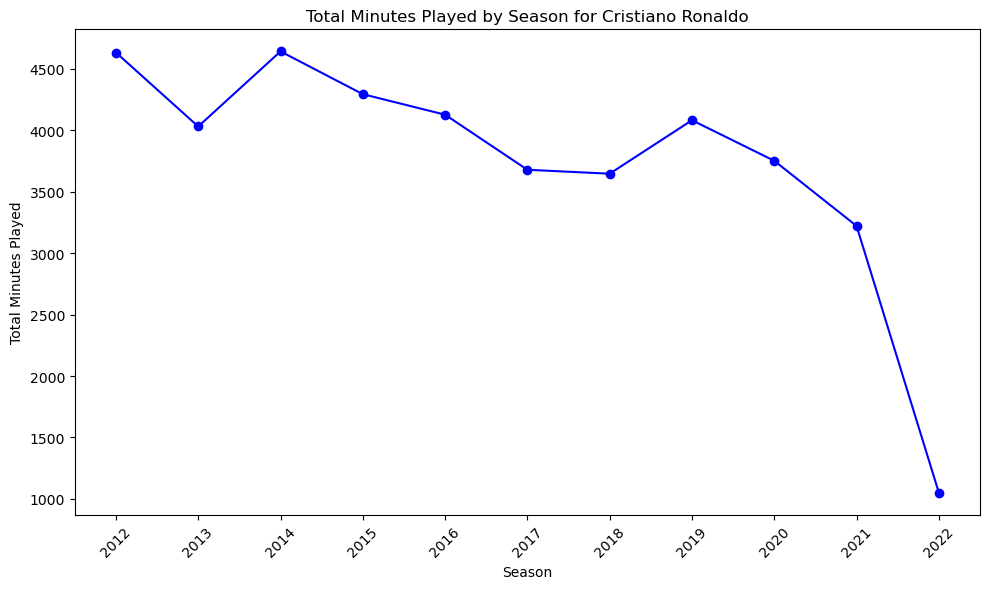

In [99]:
def plot_minutes_played_by_season(player_id, season_start, season_end):
    appearances_collection = mongo_db['appearances']
    #games_collection = mongo_db['games']

    pipeline = [
        {'$match': {'player_id': player_id}},
        {
            '$lookup': {
                'from': 'games',
                'localField': 'game_id',
                'foreignField': 'game_id',
                'as': 'game_info'
            }
        },
        {'$unwind': '$game_info'},
        {
            '$match': {
                'game_info.season': {'$gte': season_start, '$lte': season_end}
            }
        },
        {
            '$group': {
                '_id': '$game_info.season',
                'total_minutes': {'$sum': '$minutes_played'}
            }
        },
        {'$sort': {'_id': 1}}
    ]

    # Execute the aggregation pipeline
    mongo_result = list(appearances_collection.aggregate(pipeline))

    # Debugging step: Print the aggregation result to inspect the data
    print("MongoDB Aggregation Result:", mongo_result)

    # Create DataFrame from the aggregation result
    mongo_df = pd.DataFrame(mongo_result)
    if '_id' in mongo_df.columns:
        mongo_df.rename(columns={'_id': 'season'}, inplace=True)
    else:
        print("Error: The expected 'season' field is missing from the MongoDB aggregation result.")

    # Query  for player name
    name_query = f"""
    SELECT name
    FROM Players
    WHERE player_id = {player_id};
    """
    name_df = pd.read_sql_query(name_query, pg_engine)
    player_name = name_df['name'].iloc[0]

    fig, ax = plt.subplots(figsize=(10, 6))
    if 'season' in mongo_df.columns:
        mongo_df['season'] = mongo_df['season'].astype(str)
        x = mongo_df['season']
        minutes = mongo_df['total_minutes']

        ax.plot(x, minutes, marker='o', linestyle='-', color='b')

        ax.set_xlabel('Season')
        ax.set_ylabel('Total Minutes Played')
        ax.set_title(f'Total Minutes Played by Season for {player_name}')

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Error: Unable to plot data because the 'season' field is missing from the DataFrame.")


plot_minutes_played_by_season(player_id=8198, season_start=2009, season_end=2023)


# Average minutes played per game by a player in a season

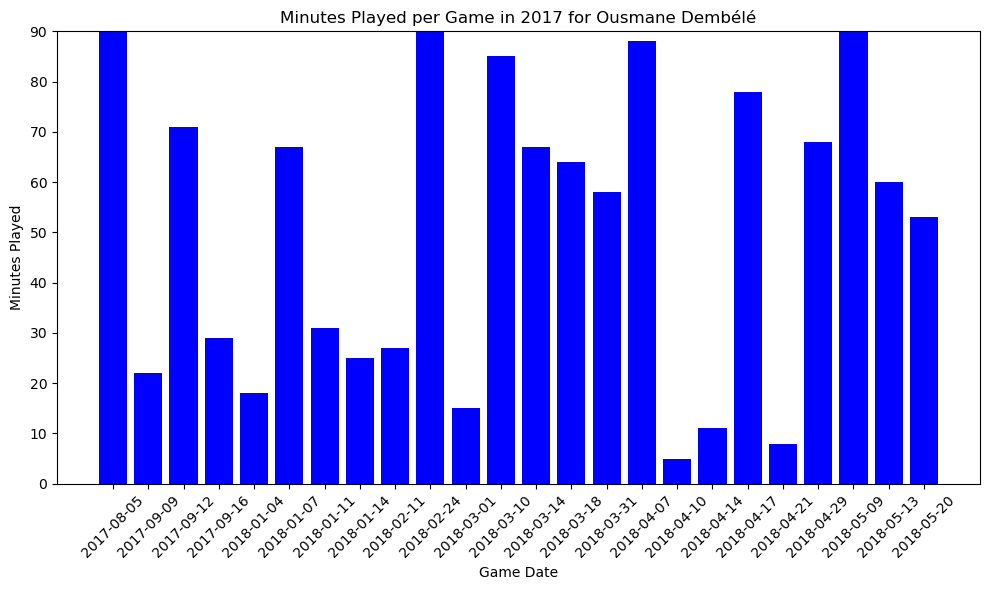

In [100]:
def plot_minutes_played_per_game(player_id, season):
    appearances_collection = mongo_db['appearances']
    #games_collection = mongo_db['games']

    season = int(season)

    pipeline = [
        {'$match': {'player_id': player_id}},
        {
            '$lookup': {
                'from': 'games',
                'localField': 'game_id',
                'foreignField': 'game_id',
                'as': 'game_info'
            }
        },
        {'$unwind': '$game_info'},
        {
            '$match': {
                'game_info.season': season
            }
        },
        {
            '$project': {
                'date': '$game_info.date',
                'minutes_played': 1
            }
        },
        {'$sort': {'date': 1}}
    ]

    mongo_df = pd.DataFrame(list(appearances_collection.aggregate(pipeline)))

    mongo_df['date'] = pd.to_datetime(mongo_df['date'])
    mongo_df['date_str'] = mongo_df['date'].dt.strftime('%Y-%m-%d')

    # Query  for player name
    name_query = f"""
    SELECT name
    FROM Players
    WHERE player_id = {player_id};
    """
    name_df = pd.read_sql_query(name_query, pg_engine)
    player_name = name_df['name'].iloc[0]

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    x = mongo_df['date_str']
    minutes = mongo_df['minutes_played']

    ax.bar(x, minutes, color='b')

    ax.set_xlabel('Game Date')
    ax.set_ylabel('Minutes Played')
    ax.set_title(f'Minutes Played per Game in {season} for {player_name}')
    ax.set_ylim(0, 90)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_minutes_played_per_game(player_id=288230, season=2017)


# Get a player's market value through his career

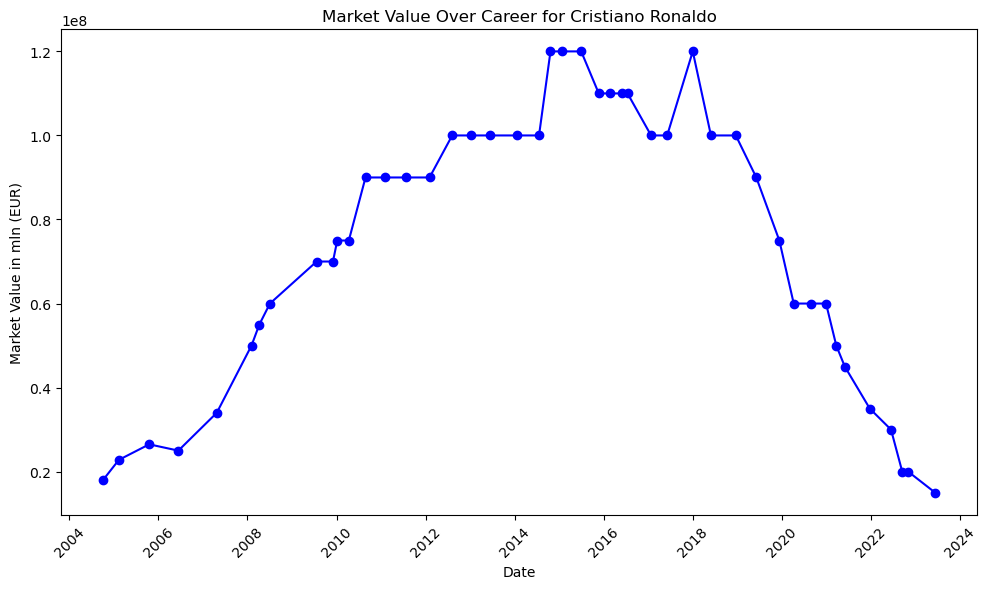

In [101]:
def plot_market_value_over_career(player_id):
    # Query to get the player's market value over time
    query = f"""
    SELECT datetime, market_value_in_eur
    FROM player_valuations
    WHERE player_id = {player_id}
    ORDER BY datetime;
    """

    df = pd.read_sql_query(query, pg_engine)

    # Query to get the player's full name
    name_query = f"""
    SELECT name
    FROM players
    WHERE player_id = {player_id};
    """

    name_df = pd.read_sql_query(name_query, pg_engine)
    player_name = name_df['name'].iloc[0]

    # Create the line plot
    fig, ax = plt.subplots(figsize=(10, 6))

    df['datetime'] = pd.to_datetime(df['datetime'])
    x = df['datetime']
    market_value = df['market_value_in_eur']

    ax.plot(x, market_value, marker='o', linestyle='-', color='b')

    ax.set_xlabel('Date')
    ax.set_ylabel('Market Value in mln (EUR)')
    ax.set_title(f'Market Value Over Career for {player_name}')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_market_value_over_career(player_id=8198)


# Players red and yellow cards per season

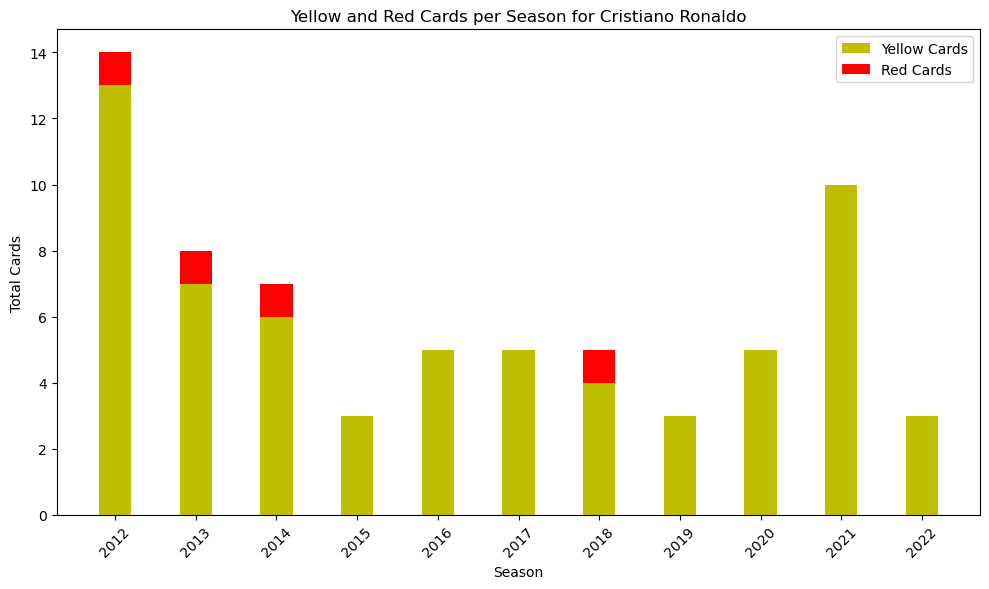

In [102]:
def plot_cards_per_season(player_id):
    appearances_collection = mongo_db['appearances']

    pipeline = [
        {'$match': {'player_id': player_id}},
        {
            '$lookup': {
                'from': 'games',
                'localField': 'game_id',
                'foreignField': 'game_id',
                'as': 'game_info'
            }
        },
        {'$unwind': '$game_info'},
        {
            '$group': {
                '_id': '$game_info.season',
                'total_yellow_cards': {'$sum': '$yellow_cards'},
                'total_red_cards': {'$sum': '$red_cards'}
            }
        },
        {'$sort': {'_id': 1}}
    ]

    mongo_df = pd.DataFrame(list(appearances_collection.aggregate(pipeline)))
    if '_id' in mongo_df.columns:
        mongo_df.rename(columns={'_id': 'season'}, inplace=True)
    else:
        print("Error: The expected 'season' field is missing from the MongoDB aggregation result.")
        return

    # Query  for player name
    name_query = f"""
    SELECT name
    FROM players
    WHERE player_id = {player_id};
    """
    name_df = pd.read_sql_query(name_query, pg_engine)
    if not name_df.empty:
        player_name = name_df['name'].iloc[0]
    else:
        player_name = "Unknown Player"

        # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    mongo_df['season'] = mongo_df['season'].astype(str)
    x = mongo_df['season']
    yellow_cards = mongo_df['total_yellow_cards']
    red_cards = mongo_df['total_red_cards']

    width = 0.4
    ax.bar(x, yellow_cards, width, label='Yellow Cards', color='y', align='center')
    ax.bar(x, red_cards, width, bottom=yellow_cards, label='Red Cards', color='r', align='center')

    ax.set_xlabel('Season')
    ax.set_ylabel('Total Cards')
    ax.set_title(f'Yellow and Red Cards per Season for {player_name}')
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_cards_per_season(player_id=8198)


# Display player's ccareer progression over seasons

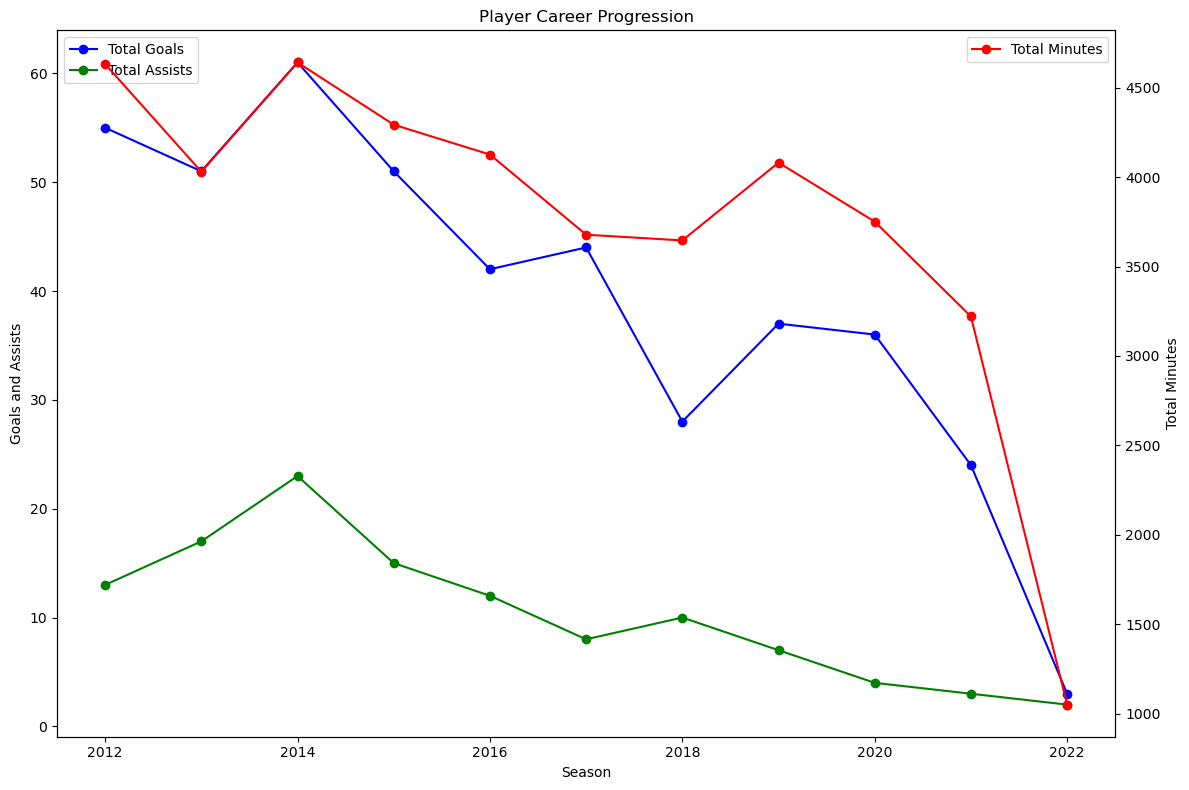

In [103]:
def visualize_progression_over_career(player_id):
    appearances_collection = mongo_db['appearances']

    pipeline = [
        {'$match': {'player_id': player_id}},
        {
            '$lookup': {
                'from': 'games',
                'localField': 'game_id',
                'foreignField': 'game_id',
                'as': 'game_info'
            }
        },
        {'$unwind': '$game_info'},
        {
            '$group': {
                '_id': '$game_info.season',
                'total_goals': {'$sum': '$goals'},
                'total_assists': {'$sum': '$assists'},
                'total_minutes': {'$sum': '$minutes_played'}
            }
        },
        {'$sort': {'_id': 1}}
    ]

    mongo_df = pd.DataFrame(list(appearances_collection.aggregate(pipeline)))
    if '_id' in mongo_df.columns:
        mongo_df.rename(columns={'_id': 'season'}, inplace=True)
    else:
        print("Error: The expected 'season' field is missing from the MongoDB aggregation result.")
        return

    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plotting goals and assists on the left y-axis
    ax1.plot(mongo_df['season'], mongo_df['total_goals'], marker='o', linestyle='-', color='b', label='Total Goals')
    ax1.plot(mongo_df['season'], mongo_df['total_assists'], marker='o', linestyle='-', color='g', label='Total Assists')
    ax1.set_xlabel('Season')
    ax1.set_ylabel('Goals and Assists')
    ax1.legend(loc='upper left')
    ax1.set_title('Player Career Progression')
    
    # Create another y-axis for total minutes
    ax2 = ax1.twinx()
    ax2.plot(mongo_df['season'], mongo_df['total_minutes'], marker='o', linestyle='-', color='r', label='Total Minutes')
    ax2.set_ylabel('Total Minutes')
    ax2.legend(loc='upper right')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

visualize_progression_over_career(player_id=8198)

# Player performance against teams


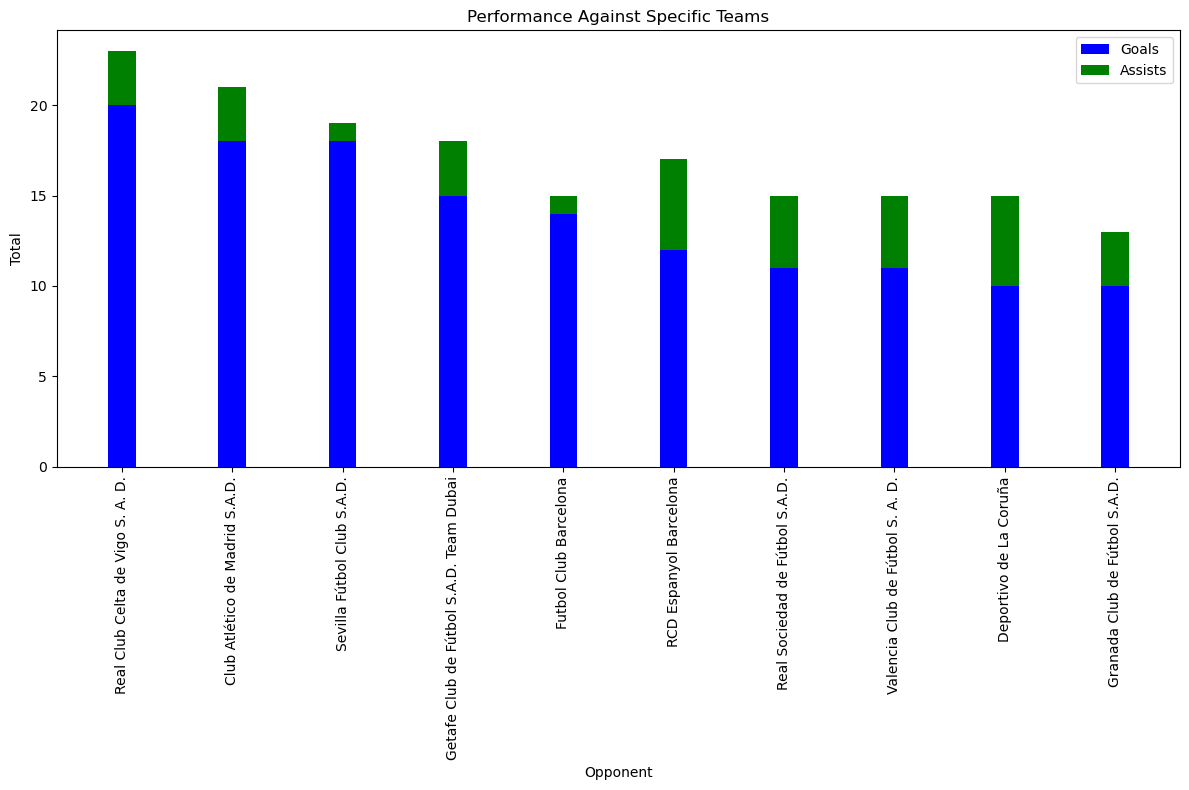

In [104]:
def analyze_performance_against_teams(player_id, season_start, season_end):
    season_start = int(season_start)
    season_end = int(season_end)

    appearances_collection = mongo_db['appearances']

    pipeline = [
        {'$match': {'player_id': player_id}},
        {
            '$lookup': {
                'from': 'games',
                'localField': 'game_id',
                'foreignField': 'game_id',
                'as': 'game_info'
            }
        },
        {'$unwind': '$game_info'},
        {
            '$match': {
                'game_info.season': {'$gte': season_start, '$lte': season_end}
            }
        },
        {
            '$project': {
                'opponent_club_id': {
                    '$cond': [
                        {'$eq': ['$player_club_id', '$game_info.home_club_id']},
                        '$game_info.away_club_id',
                        '$game_info.home_club_id'
                    ]
                },
                'goals': 1,
                'assists': 1,
                'minutes_played': 1
            }
        },
        {
            '$group': {
                '_id': '$opponent_club_id',
                'total_goals': {'$sum': '$goals'},
                'total_assists': {'$sum': '$assists'},
                'total_minutes': {'$sum': '$minutes_played'}
            }
        },
        {'$sort': {'total_goals': -1, 'total_assists': -1}},
        {'$limit': 10}
    ]

    mongo_df = pd.DataFrame(list(appearances_collection.aggregate(pipeline)))
    if '_id' in mongo_df.columns:
        mongo_df.rename(columns={'_id': 'opponent_club_id'}, inplace=True)
    else:
        print("Error: The expected 'opponent_club_id' field is missing from the MongoDB aggregation result.")
        return

    club_ids = tuple(int(club_id) for club_id in mongo_df['opponent_club_id'] if pd.notnull(club_id))

    # Query  for club names
    club_query = f"""
    SELECT club_id, name
    FROM clubs
    WHERE club_id IN {club_ids};
    """
    club_names_df = pd.read_sql_query(club_query, pg_engine)

    merged_df = mongo_df.merge(club_names_df, how='left', left_on='opponent_club_id', right_on='club_id')

    # we're making sure there are no NaN values and the type is integer
    merged_df['opponent_club_id'] = merged_df['opponent_club_id'].fillna(-1).astype(int)
    merged_df['total_goals'] = merged_df['total_goals'].fillna(0).astype(int)
    merged_df['total_assists'] = merged_df['total_assists'].fillna(0).astype(int)
    merged_df['total_minutes'] = merged_df['total_minutes'].fillna(0).astype(int)

    fig, ax = plt.subplots(figsize=(12, 8))
    width = 0.25

    x = merged_df['name'].fillna('Unknown')
    goals = merged_df['total_goals']
    assists = merged_df['total_assists']

    ax.bar(x, goals, width, label='Goals', color='b', align='center')
    ax.bar(x, assists, width, bottom=goals, label='Assists', color='g', align='center')

    ax.set_xlabel('Opponent')
    ax.set_ylabel('Total')
    ax.set_title('Performance Against Specific Teams')
    ax.legend()

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


analyze_performance_against_teams(player_id=8198, season_start=2009, season_end=2023)


# Player's goals per minute played

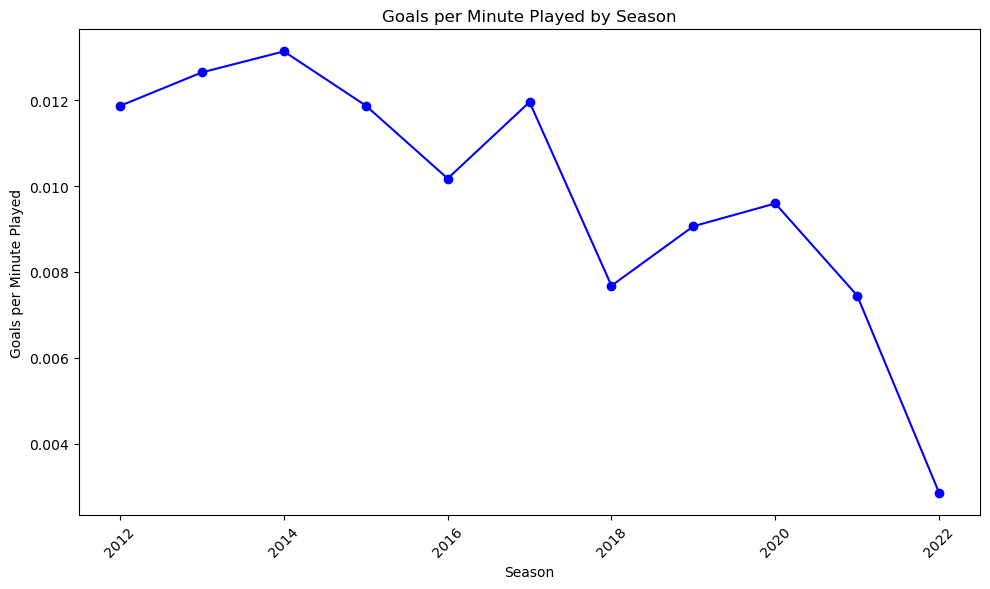

In [105]:
def plot_goals_per_minute_played(player_id, season_start, season_end):
    season_start = int(season_start)
    season_end = int(season_end)

    appearances_collection = mongo_db['appearances']

    pipeline = [
        {'$match': {'player_id': player_id}},
        {
            '$lookup': {
                'from': 'games',
                'localField': 'game_id',
                'foreignField': 'game_id',
                'as': 'game_info'
            }
        },
        {'$unwind': '$game_info'},
        {
            '$match': {
                'game_info.season': {'$gte': season_start, '$lte': season_end}
            }
        },
        {
            '$group': {
                '_id': '$game_info.season',
                'total_goals': {'$sum': '$goals'},
                'total_minutes': {'$sum': '$minutes_played'}
            }
        },
        {'$sort': {'_id': 1}}
    ]

    mongo_df = pd.DataFrame(list(appearances_collection.aggregate(pipeline)))
    if '_id' in mongo_df.columns:
        mongo_df.rename(columns={'_id': 'season'}, inplace=True)
    else:
        print("Error: The expected 'season' field is missing from the MongoDB aggregation result.")
        return

    mongo_df['goals_per_minute'] = mongo_df['total_goals'] / mongo_df['total_minutes']

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(mongo_df['season'], mongo_df['goals_per_minute'], marker='o', linestyle='-', color='b')
    ax.set_xlabel('Season')
    ax.set_ylabel('Goals per Minute Played')
    ax.set_title('Goals per Minute Played by Season')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_goals_per_minute_played(player_id=8198, season_start=2010, season_end=2023)


# Top 10 Clubs against which a player has scored the most goals

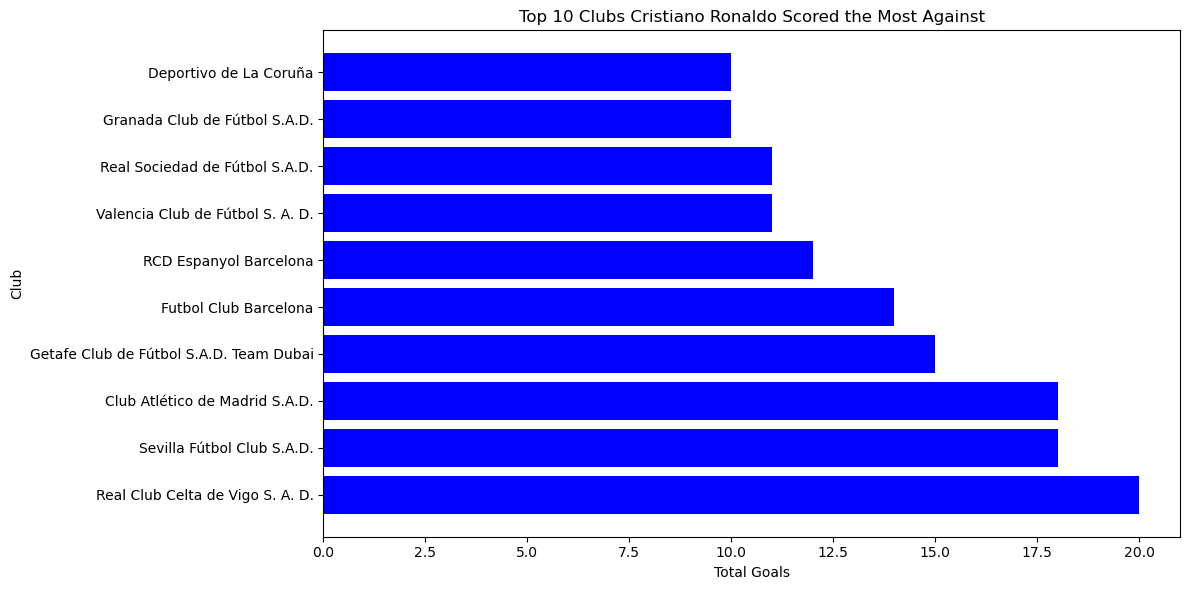

In [106]:
def plot_goals_against_top_clubs(player_id):
    appearances_collection = mongo_db['appearances']

    top_n = 10

    # MongoDB pipeline to aggregate goals by club
    pipeline = [
        {'$match': {'player_id': player_id, 'goals': {'$gt': 0}}},
        {
            '$lookup': {
                'from': 'games',
                'localField': 'game_id',
                'foreignField': 'game_id',
                'as': 'game_info'
            }
        },
        {'$unwind': '$game_info'},
        {
            '$project': {
                'club_id': {
                    '$cond': [
                        {'$eq': ['$player_club_id', '$game_info.home_club_id']},
                        '$game_info.away_club_id',
                        '$game_info.home_club_id'
                    ]
                },
                'goals': 1
            }
        },
        {
            '$group': {
                '_id': '$club_id',
                'total_goals': {'$sum': '$goals'}
            }
        },
        {'$sort': {'total_goals': -1}},
        {'$limit': top_n}
    ]


    mongo_df = pd.DataFrame(list(appearances_collection.aggregate(pipeline)))

    # Check if expected fields exist
    if '_id' in mongo_df.columns:
        mongo_df.rename(columns={'_id': 'club_id'}, inplace=True)
    else:
        print("Error: The expected 'club_id' field is missing from the MongoDB aggregation result.")
        return

    # Convert club_id to int
    mongo_df['club_id'] = mongo_df['club_id'].fillna(-1).astype(int)


    club_ids = tuple(mongo_df['club_id'])
    if len(club_ids) == 1:
        club_ids = f"({club_ids[0]})"
    else:
        club_ids = tuple(club_ids)

    #  query to fetch club names
    club_query = f"""
    SELECT club_id, name
    FROM Clubs
    WHERE club_id IN {club_ids};
    """

    # Executing postgre query
    club_names_df = pd.read_sql_query(club_query, pg_engine)

    # Merging MongoDB and postgre results
    merged_df = mongo_df.merge(club_names_df, how='left', on='club_id')
    merged_df['total_goals'] = merged_df['total_goals'].fillna(0).astype(int)


    merged_df['name'] = merged_df['name'].astype(str)

    # query to fetch player name
    name_query = f"""
    SELECT name
    FROM Players
    WHERE player_id = {player_id};
    """


    name_df = pd.read_sql_query(name_query, pg_engine)
    player_name = name_df['name'].iloc[0]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(merged_df['name'], merged_df['total_goals'], color='b')
    ax.set_xlabel('Total Goals')
    ax.set_ylabel('Club')
    ax.set_title(f'Top {top_n} Clubs {player_name} Scored the Most Against')
    plt.tight_layout()
    plt.show()


plot_goals_against_top_clubs(player_id=8198)


# Pie chart of the percentage of goals scored at home vs goals scored awaay

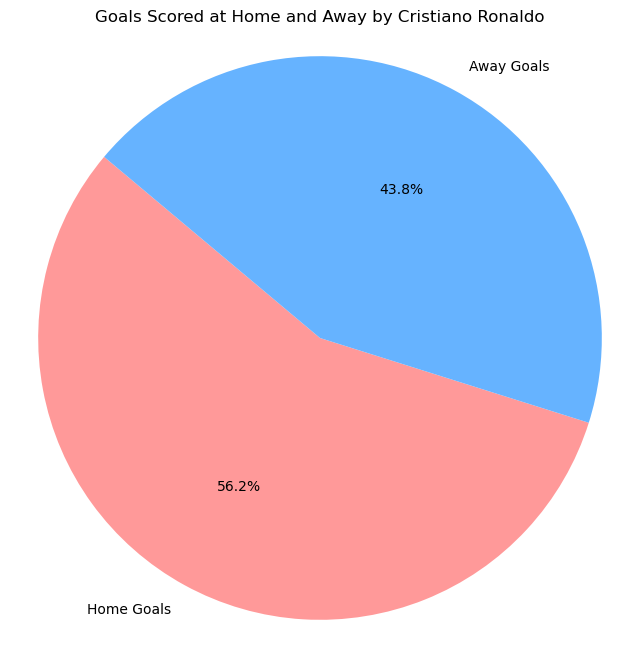

In [107]:
def plot_home_away_goals(player_id):
    appearances_collection = mongo_db['appearances']

    pipeline = [
        {'$match': {'player_id': player_id}},
        {
            '$lookup': {
                'from': 'games',
                'localField': 'game_id',
                'foreignField': 'game_id',
                'as': 'game_info'
            }
        },
        {'$unwind': '$game_info'},
        {
            '$group': {
                '_id': None,
                'home_goals': {
                    '$sum': {
                        '$cond': [{'$eq': ['$game_info.home_club_id', '$player_club_id']}, '$goals', 0]
                    }
                },
                'away_goals': {
                    '$sum': {
                        '$cond': [{'$eq': ['$game_info.away_club_id', '$player_club_id']}, '$goals', 0]
                    }
                }
            }
        }
    ]

    mongo_df = pd.DataFrame(list(appearances_collection.aggregate(pipeline)))
    if not mongo_df.empty:
        home_goals = mongo_df['home_goals'].iloc[0]
        away_goals = mongo_df['away_goals'].iloc[0]
    else:
        print("Error: No data found for the specified player in the MongoDB aggregation result.")
        return

    # Query  for player name
    name_query = f"""
    SELECT name
    FROM players
    WHERE player_id = {player_id};
    """
    name_df = pd.read_sql_query(name_query, pg_engine)
    name_df.fillna(-1)
    if not name_df.empty:
        player_name = name_df['name'].iloc[0]
    else:
        player_name = "Unknown Player"

    labels = ['Home Goals', 'Away Goals']
    sizes = [home_goals, away_goals]
    colors = ['#ff9999', '#66b3ff']

    # Create the pie chart
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')  #this is to mmake sure that it's drawn as a circle

    plt.title(f'Goals Scored at Home and Away by {player_name}')
    plt.show()


plot_home_away_goals(player_id=8198)


# Clubs analysis function

# Pie chart of club's wins losses and draws in a specific season

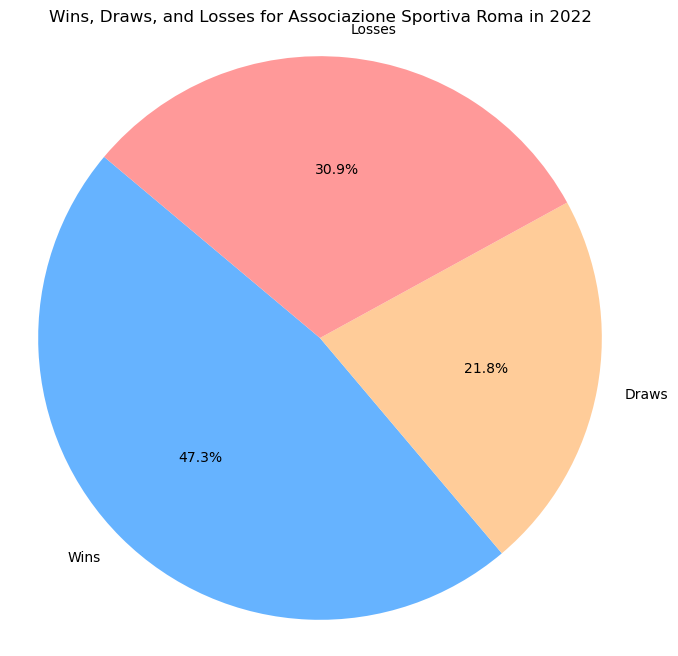

In [108]:
def plot_club_wins_draws_losses_season(club_id, season):
    season = int(season)

    games_collection = mongo_db['games']

    pipeline = [
        {'$match': {'$or': [{'home_club_id': club_id}, {'away_club_id': club_id}], 'season': season}},
        {
            '$group': {
                '_id': None,
                'wins': {
                    '$sum': {
                        '$cond': [
                            {'$or': [
                                {'$and': [{'$eq': ['$home_club_id', club_id]},
                                          {'$gt': ['$home_club_goals', '$away_club_goals']}]},
                                {'$and': [{'$eq': ['$away_club_id', club_id]},
                                          {'$gt': ['$away_club_goals', '$home_club_goals']}]}
                            ]}, 1, 0
                        ]
                    }
                },
                'draws': {
                    '$sum': {
                        '$cond': [{'$eq': ['$home_club_goals', '$away_club_goals']}, 1, 0]
                    }
                },
                'losses': {
                    '$sum': {
                        '$cond': [
                            {'$or': [
                                {'$and': [{'$eq': ['$home_club_id', club_id]},
                                          {'$lt': ['$home_club_goals', '$away_club_goals']}]},
                                {'$and': [{'$eq': ['$away_club_id', club_id]},
                                          {'$lt': ['$away_club_goals', '$home_club_goals']}]}
                            ]}, 1, 0
                        ]
                    }
                }
            }
        }
    ]

    mongo_df = pd.DataFrame(list(games_collection.aggregate(pipeline)))
    if not mongo_df.empty:
        wins = int(mongo_df['wins'].iloc[0])
        draws = int(mongo_df['draws'].iloc[0])
        losses = int(mongo_df['losses'].iloc[0])
    else:
        print("Error: No data found for the specified club and season in the MongoDB aggregation result.")
        return

    # Query for club name
    name_query = f"""
    SELECT name
    FROM clubs
    WHERE club_id = {club_id};
    """
    name_df = pd.read_sql_query(name_query, pg_engine)
    if not name_df.empty:
        club_name = name_df['name'].iloc[0]
    else:
        club_name = "Unknown Club"

        # Data for the pie chart
    labels = ['Wins', 'Draws', 'Losses']
    sizes = [wins, draws, losses]
    colors = ['#66b3ff', '#ffcc99', '#ff9999']

    # Create the pie chart
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')  # we're making sure the graph is a circle

    plt.title(f'Wins, Draws, and Losses for {club_name} in {season}')
    plt.show()


plot_club_wins_draws_losses_season(club_id=12, season=2022)


# Line chart displaying wins, draws, losses of a club between 2 seasons

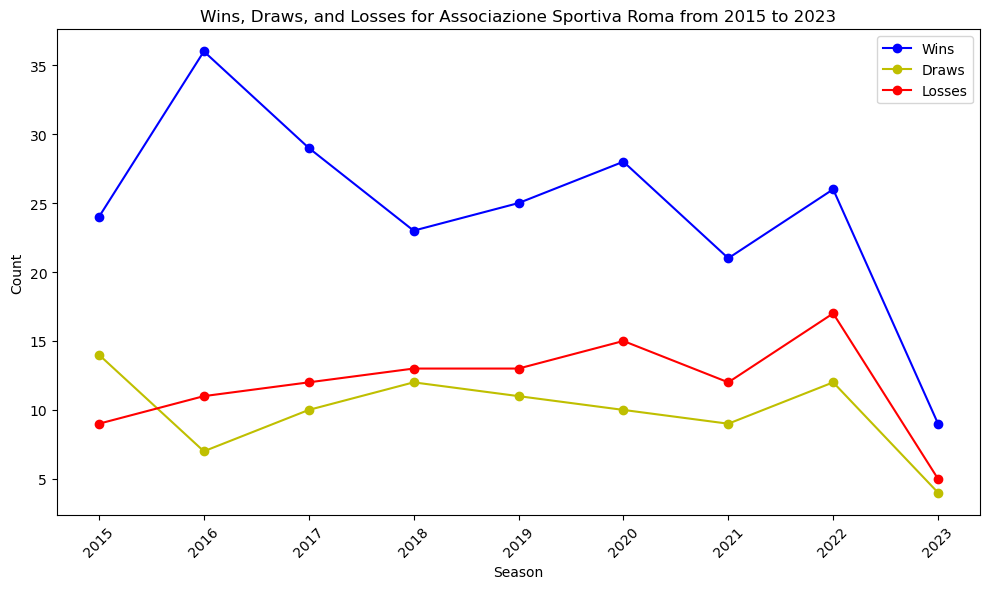

In [109]:
def plot_club_wins_draws_losses_seasons(club_id, season_start, season_end):
    season_start = int(season_start)
    season_end = int(season_end)

    games_collection = mongo_db['games']

    pipeline = [
        {'$match': {'$or': [{'home_club_id': club_id}, {'away_club_id': club_id}],
                    'season': {'$gte': season_start, '$lte': season_end}}},
        {
            '$group': {
                '_id': '$season',
                'wins': {
                    '$sum': {
                        '$cond': [
                            {'$or': [
                                {'$and': [{'$eq': ['$home_club_id', club_id]},
                                          {'$gt': ['$home_club_goals', '$away_club_goals']}]},
                                {'$and': [{'$eq': ['$away_club_id', club_id]},
                                          {'$gt': ['$away_club_goals', '$home_club_goals']}]}
                            ]}, 1, 0
                        ]
                    }
                },
                'draws': {
                    '$sum': {
                        '$cond': [{'$eq': ['$home_club_goals', '$away_club_goals']}, 1, 0]
                    }
                },
                'losses': {
                    '$sum': {
                        '$cond': [
                            {'$or': [
                                {'$and': [{'$eq': ['$home_club_id', club_id]},
                                          {'$lt': ['$home_club_goals', '$away_club_goals']}]},
                                {'$and': [{'$eq': ['$away_club_id', club_id]},
                                          {'$lt': ['$away_club_goals', '$home_club_goals']}]}
                            ]}, 1, 0
                        ]
                    }
                }
            }
        },
        {'$sort': {'_id': 1}}
    ]

    mongo_df = pd.DataFrame(list(games_collection.aggregate(pipeline)))
    if '_id' in mongo_df.columns:
        mongo_df.rename(columns={'_id': 'season'}, inplace=True)
    else:
        print("Error: The expected 'season' field is missing from the MongoDB aggregation result.")
        return

    # Query  for club name
    name_query = f"""
    SELECT name
    FROM clubs
    WHERE club_id = {club_id};
    """
    name_df = pd.read_sql_query(name_query, pg_engine)
    if not name_df.empty:
        club_name = name_df['name'].iloc[0]
    else:
        club_name = "Unknown Club"

        # Create the line plot
    fig, ax = plt.subplots(figsize=(10, 6))

    mongo_df['season'] = mongo_df['season'].astype(str)

    ax.plot(mongo_df['season'], mongo_df['wins'], marker='o', linestyle='-', color='b', label='Wins')
    ax.plot(mongo_df['season'], mongo_df['draws'], marker='o', linestyle='-', color='y', label='Draws')
    ax.plot(mongo_df['season'], mongo_df['losses'], marker='o', linestyle='-', color='r', label='Losses')

    ax.set_xlabel('Season')
    ax.set_ylabel('Count')
    ax.set_title(f'Wins, Draws, and Losses for {club_name} from {season_start} to {season_end}')
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_club_wins_draws_losses_seasons(club_id=12, season_start=2015, season_end=2023)


# Total goals scored and conceded per season by a club

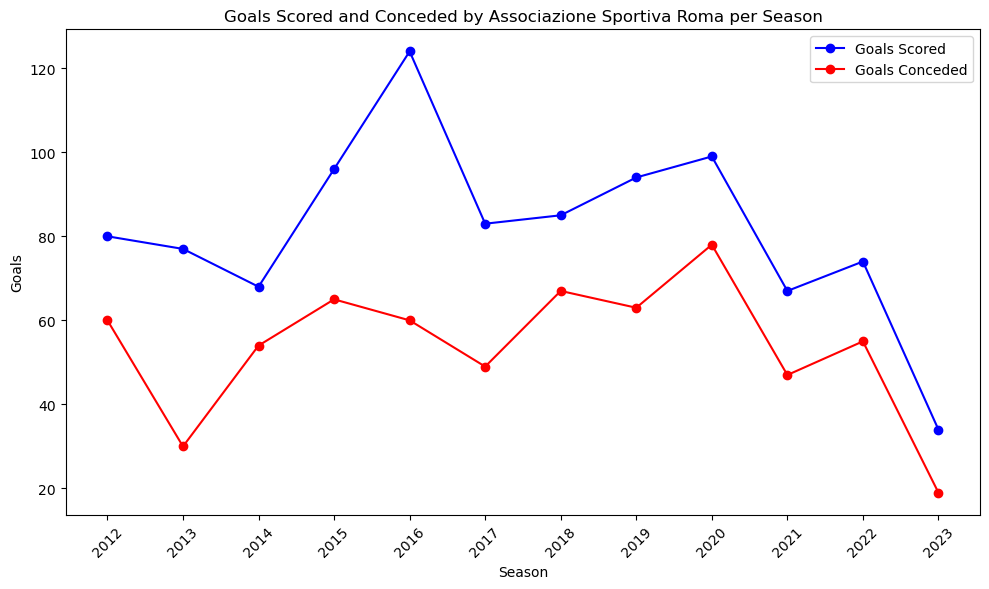

In [110]:
def plot_goals_scored_conceded_season(club_id):
    games_collection = mongo_db['games']

    pipeline = [
        {'$match': {'$or': [{'home_club_id': club_id}, {'away_club_id': club_id}]}},
        {
            '$group': {
                '_id': '$season',
                'goals_scored': {
                    '$sum': {
                        '$cond': [
                            {'$eq': ['$home_club_id', club_id]},
                            '$home_club_goals',
                            '$away_club_goals'
                        ]
                    }
                },
                'goals_conceded': {
                    '$sum': {
                        '$cond': [
                            {'$eq': ['$home_club_id', club_id]},
                            '$away_club_goals',
                            '$home_club_goals'
                        ]
                    }
                }
            }
        },
        {'$sort': {'_id': 1}}
    ]

    mongo_df = pd.DataFrame(list(games_collection.aggregate(pipeline)))
    if '_id' in mongo_df.columns:
        mongo_df.rename(columns={'_id': 'season'}, inplace=True)
    else:
        print("Error: The expected 'season' field is missing from the MongoDB aggregation result.")
        return

    # Query for club name
    name_query = f"""
    SELECT name
    FROM clubs
    WHERE club_id = {club_id};
    """
    name_df = pd.read_sql_query(name_query, pg_engine)
    if not name_df.empty:
        club_name = name_df['name'].iloc[0]
    else:
        club_name = "Unknown Club"

        # Create the line plot
    fig, ax = plt.subplots(figsize=(10, 6))
    mongo_df['season'] = mongo_df['season'].astype(str)

    ax.plot(mongo_df['season'], mongo_df['goals_scored'], marker='o', linestyle='-', color='b', label='Goals Scored')
    ax.plot(mongo_df['season'], mongo_df['goals_conceded'], marker='o', linestyle='-', color='r',
            label='Goals Conceded')

    ax.set_xlabel('Season')
    ax.set_ylabel('Goals')
    ax.set_title(f'Goals Scored and Conceded by {club_name} per Season')
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_goals_scored_conceded_season(club_id=12)


# Home vs away performance of a club in a season

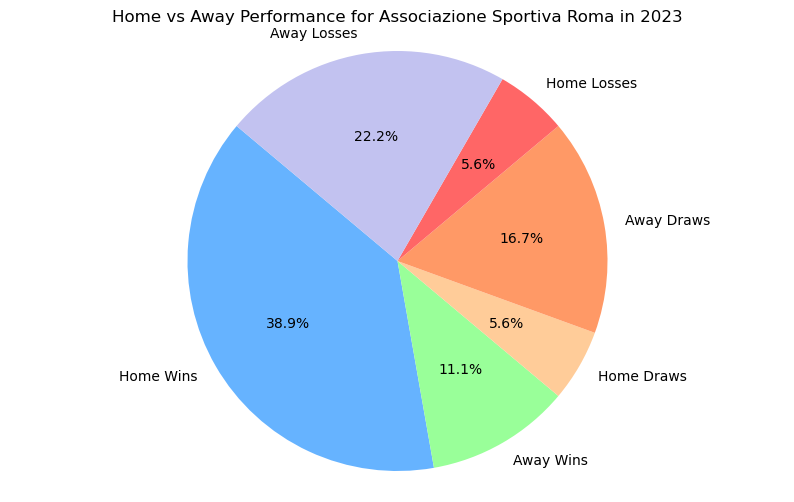

In [111]:
def plot_home_away_performance_season(club_id, season):
    games_collection = mongo_db['games']

    pipeline = [
        {'$match': {'$or': [{'home_club_id': club_id}, {'away_club_id': club_id}], 'season': season}},
        {
            '$group': {
                '_id': None,
                'home_wins': {
                    '$sum': {
                        '$cond': [
                            {'$and': [{'$eq': ['$home_club_id', club_id]},
                                      {'$gt': ['$home_club_goals', '$away_club_goals']}]},
                            1, 0
                        ]
                    }
                },
                'away_wins': {
                    '$sum': {
                        '$cond': [
                            {'$and': [{'$eq': ['$away_club_id', club_id]},
                                      {'$gt': ['$away_club_goals', '$home_club_goals']}]},
                            1, 0
                        ]
                    }
                },
                'home_losses': {
                    '$sum': {
                        '$cond': [
                            {'$and': [{'$eq': ['$home_club_id', club_id]},
                                      {'$lt': ['$home_club_goals', '$away_club_goals']}]},
                            1, 0
                        ]
                    }
                },
                'away_losses': {
                    '$sum': {
                        '$cond': [
                            {'$and': [{'$eq': ['$away_club_id', club_id]},
                                      {'$lt': ['$away_club_goals', '$home_club_goals']}]},
                            1, 0
                        ]
                    }
                },
                'home_draws': {
                    '$sum': {
                        '$cond': [
                            {'$and': [{'$eq': ['$home_club_id', club_id]},
                                      {'$eq': ['$home_club_goals', '$away_club_goals']}]},
                            1, 0
                        ]
                    }
                },
                'away_draws': {
                    '$sum': {
                        '$cond': [
                            {'$and': [{'$eq': ['$away_club_id', club_id]},
                                      {'$eq': ['$home_club_goals', '$away_club_goals']}]},
                            1, 0
                        ]
                    }
                }
            }
        }
    ]

    mongo_df = pd.DataFrame(list(games_collection.aggregate(pipeline)))
    if not mongo_df.empty:
        home_wins = mongo_df['home_wins'].iloc[0]
        away_wins = mongo_df['away_wins'].iloc[0]
        home_draws = mongo_df['home_draws'].iloc[0]
        away_draws = mongo_df['away_draws'].iloc[0]
        home_losses = mongo_df['home_losses'].iloc[0]
        away_losses = mongo_df['away_losses'].iloc[0]
    else:
        print("Error: No data found for the specified club and season in the MongoDB aggregation result.")
        return

    name_query = f"""
    SELECT name
    FROM clubs
    WHERE club_id = {club_id};
    """
    name_df = pd.read_sql_query(name_query, pg_engine)
    if not name_df.empty:
        club_name = name_df['name'].iloc[0]
    else:
        club_name = "Unknown Club"

    labels = ['Home Wins', 'Away Wins', 'Home Draws', 'Away Draws', 'Home Losses', 'Away Losses']
    sizes = [home_wins, away_wins, home_draws, away_draws, home_losses, away_losses]
    colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9966', '#ff6666', '#c2c2f0']

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')

    plt.title(f'Home vs Away Performance for {club_name} in {season}')
    plt.show()


plot_home_away_performance_season(club_id=12, season=2023)


# Points gained per season by a club

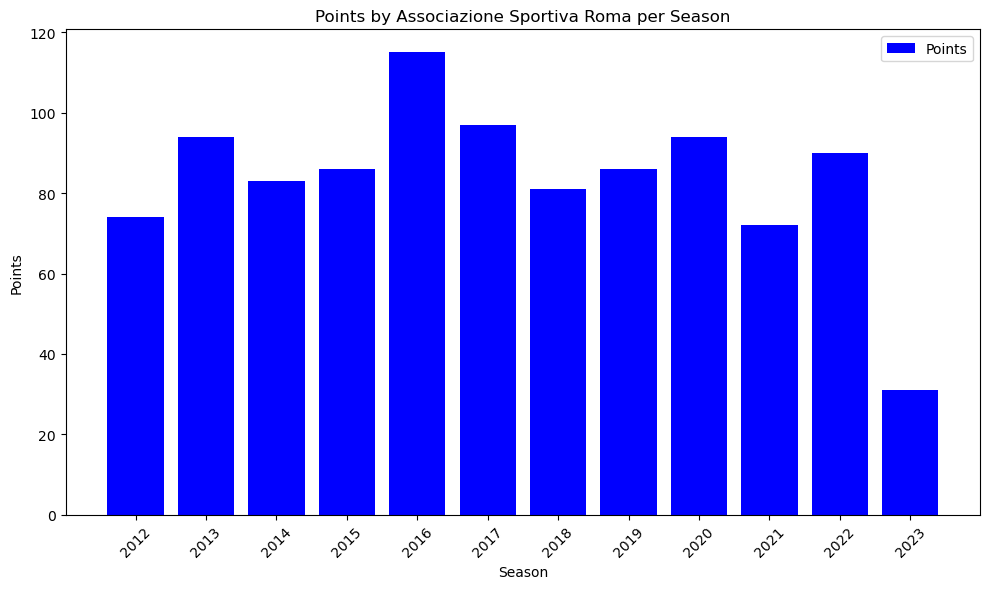

In [112]:
def plot_points_per_season(club_id):
    games_collection = mongo_db['games']

    pipeline = [
        {'$match': {'$or': [{'home_club_id': club_id}, {'away_club_id': club_id}]}},
        {
            '$group': {
                '_id': '$season',
                'points': {
                    '$sum': {
                        '$cond': [
                            {'$or': [
                                {'$and': [{'$eq': ['$home_club_id', club_id]},
                                          {'$gt': ['$home_club_goals', '$away_club_goals']}]},
                                {'$and': [{'$eq': ['$away_club_id', club_id]},
                                          {'$gt': ['$away_club_goals', '$home_club_goals']}]}
                            ]}, 3,
                            {'$cond': [
                                {'$eq': ['$home_club_goals', '$away_club_goals']}, 1, 0
                            ]}
                        ]
                    }
                }
            }
        },
        {'$sort': {'_id': 1}}
    ]

    mongo_df = pd.DataFrame(list(games_collection.aggregate(pipeline)))
    if '_id' in mongo_df.columns:
        mongo_df.rename(columns={'_id': 'season'}, inplace=True)
    else:
        print("Error: The expected 'season' field is missing from the MongoDB aggregation result.")
        return

    name_query = f"""
    SELECT name
    FROM clubs
    WHERE club_id = {club_id};
    """
    name_df = pd.read_sql_query(name_query, pg_engine)
    if not name_df.empty:
        club_name = name_df['name'].iloc[0]
    else:
        club_name = "Unknown Club"

    fig, ax = plt.subplots(figsize=(10, 6))
    mongo_df['season'] = mongo_df['season'].astype(str)

    # Change from line plot to bar chart
    ax.bar(mongo_df['season'], mongo_df['points'], color='b', label='Points')

    ax.set_xlabel('Season')
    ax.set_ylabel('Points')
    ax.set_title(f'Points by {club_name} per Season')
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_points_per_season(club_id=12)

# Market Value of a Squad Over time

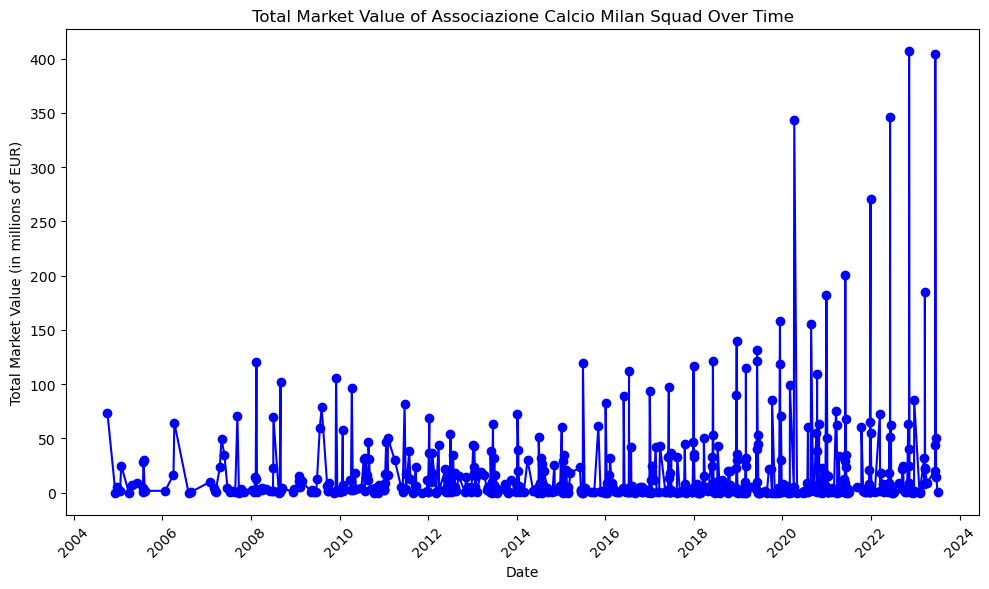

In [113]:
def plot_squad_market_value(club_id):
    query = f"""
    SELECT pv.datetime, SUM(pv.market_value_in_eur) AS total_market_value
    FROM player_valuations pv
    JOIN players p ON pv.player_id = p.player_id
    WHERE p.current_club_id = {club_id}
    GROUP BY pv.datetime
    ORDER BY pv.datetime;
    """

    df = pd.read_sql_query(query, pg_engine)

    # Query to get the club's name
    name_query = f"""
    SELECT name
    FROM clubs
    WHERE club_id = {club_id};
    """

    name_df = pd.read_sql_query(name_query, pg_engine)
    club_name = name_df['name'].iloc[0]

    # Converting market value to millions of EUR
    df['total_market_value'] = df['total_market_value'] / 1e6

    fig, ax = plt.subplots(figsize=(10, 6))

    df['datetime'] = pd.to_datetime(df['datetime'])
    x = df['datetime']
    market_value = df['total_market_value']

    ax.plot(x, market_value, marker='o', linestyle='-', color='b')

    ax.set_xlabel('Date')
    ax.set_ylabel('Total Market Value (in millions of EUR)')
    ax.set_title(f'Total Market Value of {club_name} Squad Over Time')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_squad_market_value(club_id=5)


# Display correlations between market value of squad and wins per season

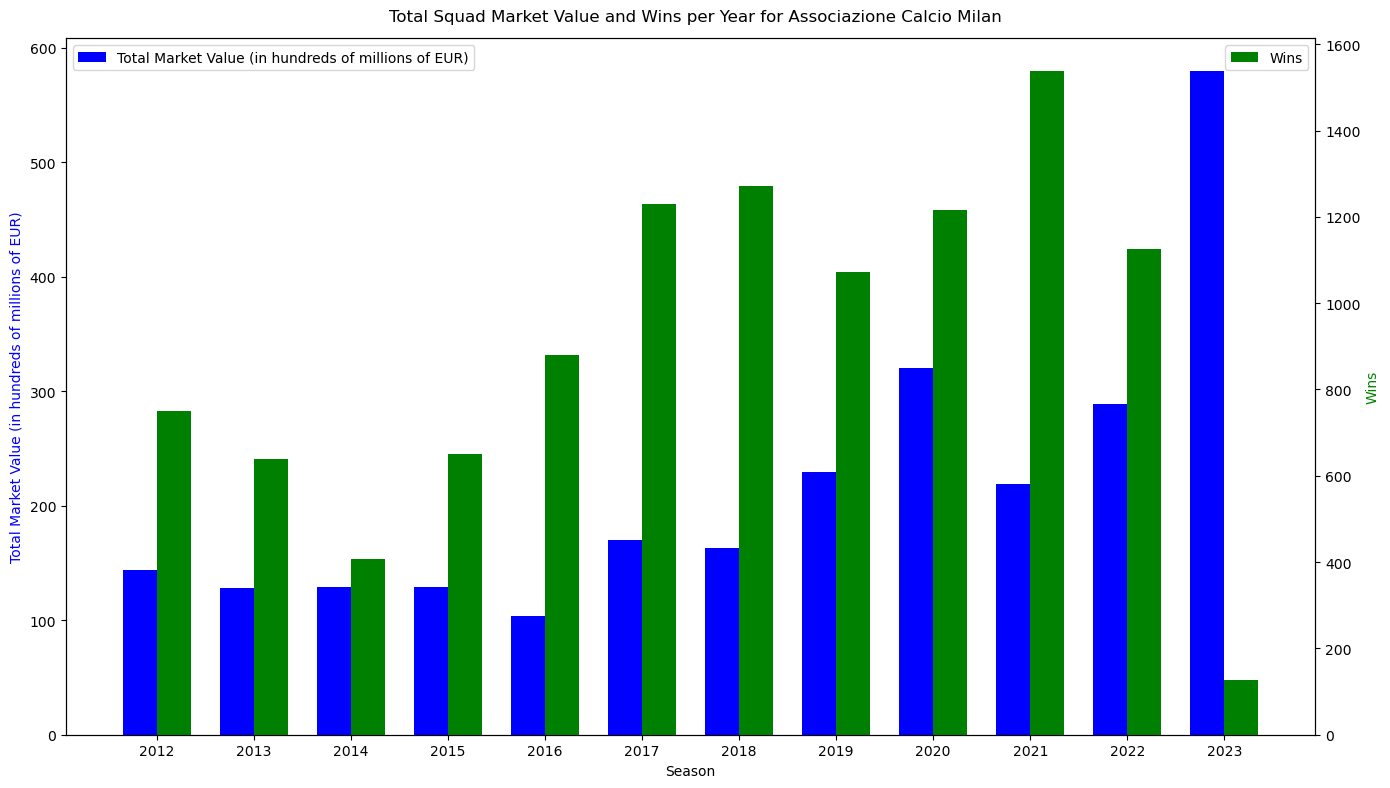

In [114]:
def plot_squad_market_value_and_wins(club_id):
    games_collection = mongo_db['games']

    # Query to get the total market value of the squad per season 
    market_value_query = f"""
    SELECT pv.date, SUM(pv.market_value_in_eur) AS total_market_value
    FROM player_valuations pv
    JOIN players p ON pv.player_id = p.player_id
    WHERE p.current_club_id = {club_id}
    GROUP BY pv.date
    ORDER BY pv.date;
    """

    market_value_df = pd.read_sql_query(market_value_query, pg_engine)

    # Converting market value to hundreds of millions of EUR
    market_value_df['total_market_value'] = market_value_df['total_market_value'] / 1e5

    # Extracting the season (year) from the date in market_value_df
    market_value_df['season'] = pd.to_datetime(market_value_df['date']).dt.year

    pipeline = [
        {'$match': {'$or': [{'home_club_id': club_id}, {'away_club_id': club_id}]}},
        {
            '$group': {
                '_id': '$season',
                'wins': {
                    '$sum': {
                        '$cond': [
                            {'$or': [
                                {'$and': [{'$eq': ['$home_club_id', club_id]},
                                          {'$gt': ['$home_club_goals', '$away_club_goals']}]},
                                {'$and': [{'$eq': ['$away_club_id', club_id]},
                                          {'$gt': ['$away_club_goals', '$home_club_goals']}]}
                            ]}, 1, 0
                        ]
                    }
                }
            }
        },
        {'$sort': {'_id': 1}}
    ]

    wins_df = pd.DataFrame(list(games_collection.aggregate(pipeline)))
    if '_id' in wins_df.columns:
        wins_df.rename(columns={'_id': 'season'}, inplace=True)
    else:
        print("Error: The expected 'season' field is missing from the MongoDB aggregation result.")
        return

    # Merging market value and wins data on the season
    merged_df = pd.merge(market_value_df, wins_df, on='season', how='inner')

    # Grouping by one-year intervals
    grouped_df = merged_df.groupby('season').agg({
        'total_market_value': 'mean',
        'wins': 'sum'
    }).reset_index()

    # Query to get the club's name 
    name_query = f"""
    SELECT name
    FROM clubs
    WHERE club_id = {club_id};
    """

    name_df = pd.read_sql_query(name_query, pg_engine)
    club_name = name_df['name'].iloc[0]

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Bar width
    bar_width = 0.35

    # Positions of the bars on the x-axis
    seasons = grouped_df['season'].astype(str)
    bar1_positions = range(len(seasons))
    bar2_positions = [p + bar_width for p in bar1_positions]

    # Create bars for market value
    ax1.bar(bar1_positions, grouped_df['total_market_value'], width=bar_width, label='Total Market Value (in hundreds of millions of EUR)', color='b')

    # Create bars for wins
    ax2 = ax1.twinx()
    ax2.bar(bar2_positions, grouped_df['wins'], width=bar_width, label='Wins', color='g')

    # Labeling the x-axis
    ax1.set_xlabel('Season')
    ax1.set_xticks([p + bar_width/2 for p in bar1_positions])
    ax1.set_xticklabels(seasons)

    # Labeling the y-axes
    ax1.set_ylabel('Total Market Value (in hundreds of millions of EUR)', color='b')
    ax2.set_ylabel('Wins', color='g')

    # Adding title
    fig.suptitle(f'Total Squad Market Value and Wins per Year for {club_name}')

    # Adding legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.show()

plot_squad_market_value_and_wins(club_id=5)

# Wins and losses and Draws under different managers 

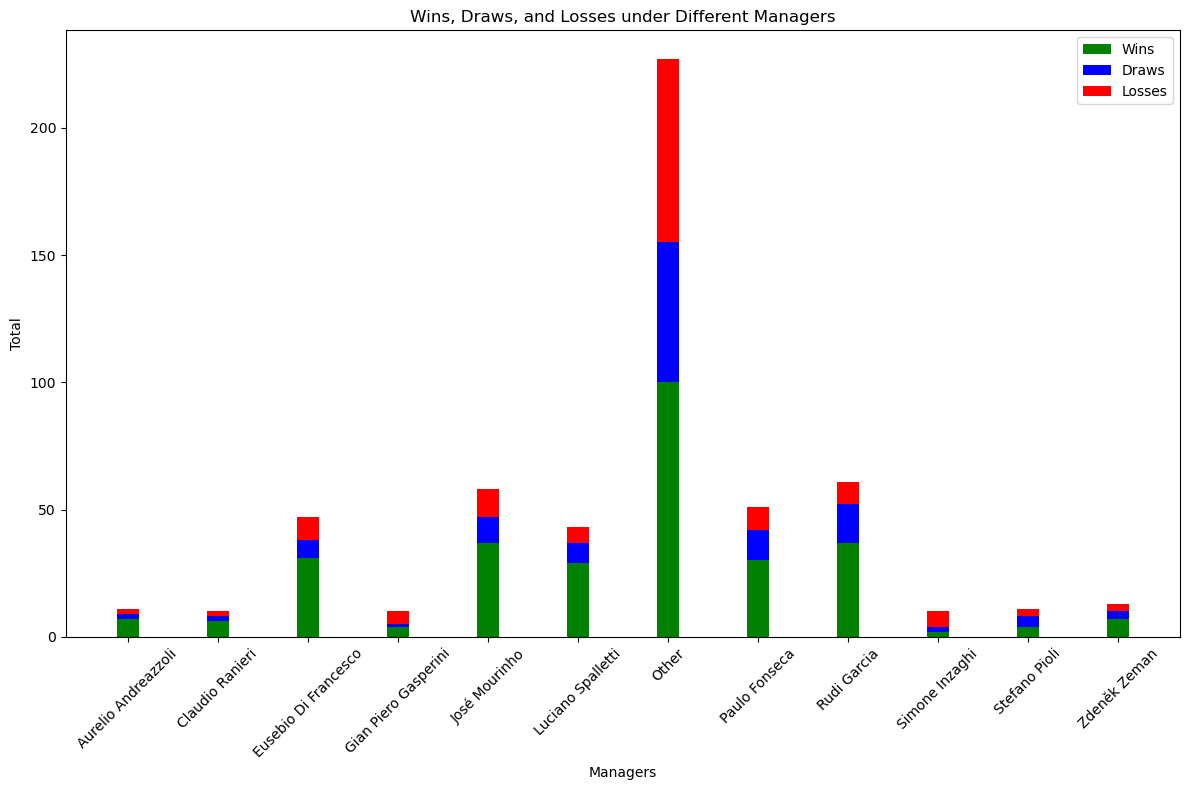

In [115]:
def plot_wins_draws_losses_managers_grouped(club_id):
    threshold = 10
    games_collection = mongo_db['games']

    pipeline = [
        {
            '$match': {
                '$or': [
                    {'home_club_id': club_id},
                    {'away_club_id': club_id}
                ]
            }
        },
        {
            '$group': {
                '_id': '$home_club_manager_name',
                'games_managed': {'$sum': 1},
                'wins': {
                    '$sum': {
                        '$cond': [
                            {
                                '$or': [
                                    {'$and': [{'$eq': ['$home_club_id', club_id]},
                                              {'$gt': ['$home_club_goals', '$away_club_goals']}]},
                                    {'$and': [{'$eq': ['$away_club_id', club_id]},
                                              {'$gt': ['$away_club_goals', '$home_club_goals']}]}
                                ]
                            },
                            1,
                            0
                        ]
                    }
                },
                'draws': {
                    '$sum': {
                        '$cond': [{'$eq': ['$home_club_goals', '$away_club_goals']}, 1, 0]
                    }
                },
                'losses': {
                    '$sum': {
                        '$cond': [
                            {
                                '$or': [
                                    {'$and': [{'$eq': ['$home_club_id', club_id]},
                                              {'$lt': ['$home_club_goals', '$away_club_goals']}]},
                                    {'$and': [{'$eq': ['$away_club_id', club_id]},
                                              {'$lt': ['$away_club_goals', '$home_club_goals']}]}
                                ]
                            },
                            1,
                            0
                        ]
                    }
                }
            }
        }
    ]

    df = pd.DataFrame(list(games_collection.aggregate(pipeline)))

    if df.empty or '_id' not in df.columns:
        print("Error: No data found for the specified club.")
        return

    df.rename(columns={'_id': 'manager'}, inplace=True)

    # Grouping 'other' categories
    df['manager'] = df.apply(lambda row: row['manager'] if row['games_managed'] >= threshold else 'Other', axis=1)
    df_grouped = df.groupby('manager').sum().reset_index()

    managers = df_grouped['manager']
    wins = df_grouped['wins']
    draws = df_grouped['draws']
    losses = df_grouped['losses']

    bar_width = 0.25
    index = range(len(managers))

    plt.figure(figsize=(12, 8))
    bar1 = plt.bar(index, wins, bar_width, label='Wins', color='g')
    bar2 = plt.bar(index, draws, bar_width, bottom=wins, label='Draws', color='b')
    bar3 = plt.bar(index, losses, bar_width, bottom=wins + draws, label='Losses', color='r')

    plt.xlabel('Managers')
    plt.ylabel('Total')
    plt.title('Wins, Draws, and Losses under Different Managers')
    plt.xticks(index, managers, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_wins_draws_losses_managers_grouped(club_id=12)

# Goals Scored and Conceded under Different Managers

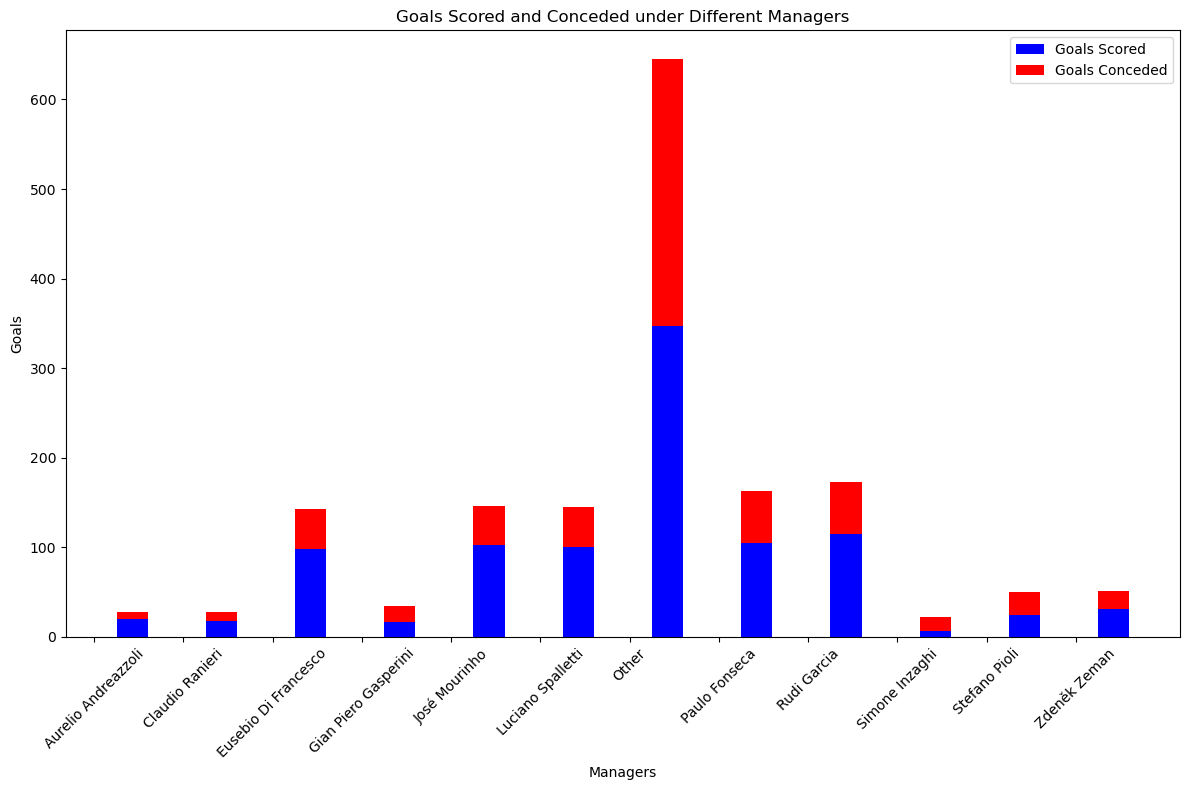

In [116]:
def plot_goals_scored_conceded_managers_grouped(club_id):
    threshold = 10
    games_collection = mongo_db['games']

    pipeline = [
        {
            '$match': {
                '$or': [{'home_club_id': club_id}, {'away_club_id': club_id}]
            }
        },
        {
            '$group': {
                '_id': '$home_club_manager_name',
                'games_managed': {'$sum': 1},
                'goals_scored': {
                    '$sum': {
                        '$cond': [
                            {'$eq': ['$home_club_id', club_id]},
                            '$home_club_goals',
                            '$away_club_goals'
                        ]
                    }
                },
                'goals_conceded': {
                    '$sum': {
                        '$cond': [
                            {'$eq': ['$home_club_id', club_id]},
                            '$away_club_goals',
                            '$home_club_goals'
                        ]
                    }
                }
            }
        }
    ]

    df = pd.DataFrame(list(games_collection.aggregate(pipeline)))

    if df.empty or '_id' not in df.columns:
        print("Error: No data found for the specified club.")
        return

    df.rename(columns={'_id': 'manager'}, inplace=True)

    # Group smaller categories
    df['manager'] = df.apply(lambda row: row['manager'] if row['games_managed'] >= threshold else 'Other', axis=1)
    df_grouped = df.groupby('manager').sum().reset_index()

    # Data for the bar chart
    managers = df_grouped['manager']
    goals_scored = df_grouped['goals_scored']
    goals_conceded = df_grouped['goals_conceded']

    bar_width = 0.35
    index = range(len(managers))

    plt.figure(figsize=(12, 8))
    bar1 = plt.bar(index, goals_scored, bar_width, label='Goals Scored', color='b')
    bar2 = plt.bar(index, goals_conceded, bar_width, label='Goals Conceded', color='r', bottom=goals_scored)

    plt.xlabel('Managers')
    plt.ylabel('Goals')
    plt.title('Goals Scored and Conceded under Different Managers')
    plt.xticks([i - 0.6 + bar_width / 2 for i in index], managers, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()



plot_goals_scored_conceded_managers_grouped(club_id=12)

# Competition Data Analysis Functions

# Display the competition top Scorers

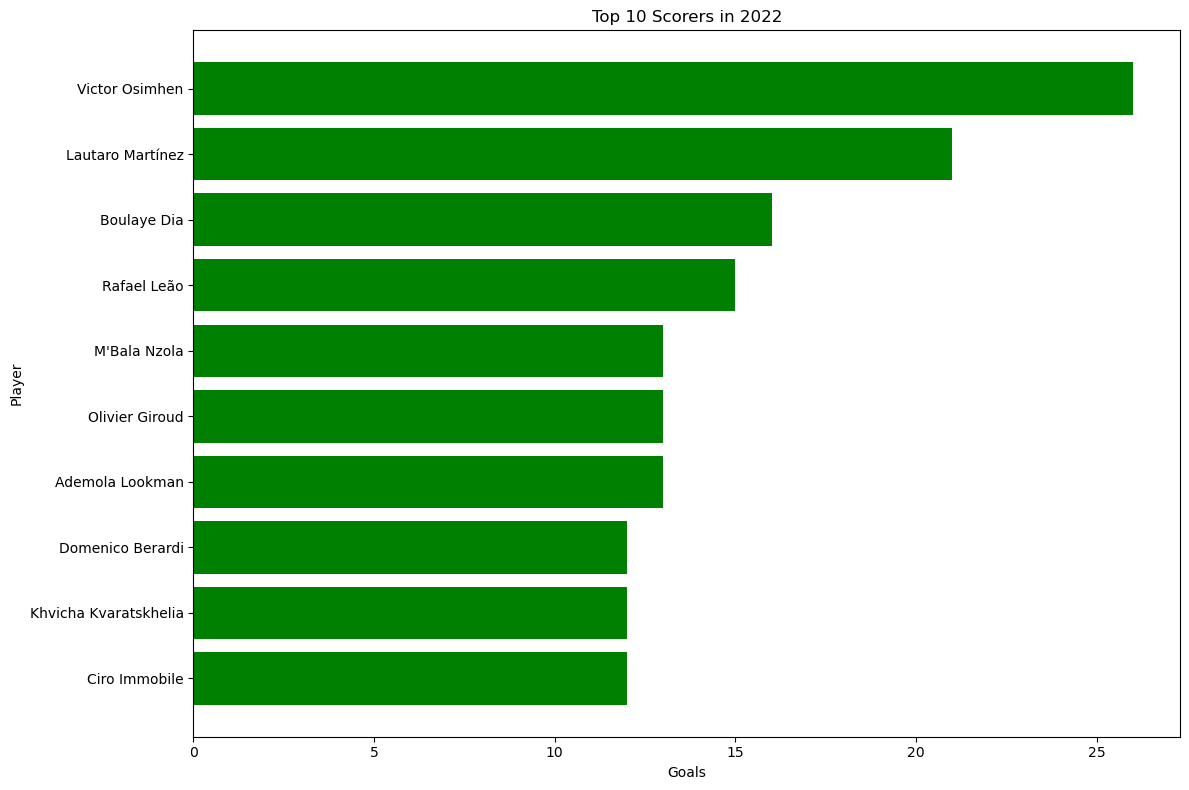

In [117]:
def plot_top_scorers(competition_id, season):
    
    #i had to divide the pipelines because making a single one was too heavy
    appearances_collection = mongo_db['appearances']
    games_collection = mongo_db['games']

    game_ids = list(games_collection.find(
        {'competition_id': competition_id, 'season': season},
        {'game_id': 1, '_id': 0}
    ))
    game_ids = [game['game_id'] for game in game_ids]

    if not game_ids:
        print("No games found for the specified competition and season.")
        return

    pipeline = [
        {'$match': {'game_id': {'$in': game_ids}}},
        {'$group': {'_id': '$player_id', 'total_goals': {'$sum': '$goals'}}},
        {'$sort': {'total_goals': -1}},
        {'$limit': 10}
    ]
    
    mongo_df = pd.DataFrame(list(appearances_collection.aggregate(pipeline)))
    
    if mongo_df.empty:
        print("No data found for the specified competition and season.")
        return
    
    # get player names from PostgreSQL
    player_ids = ','.join(map(str, mongo_df['_id']))
    pg_query = f"SELECT player_id, name FROM players WHERE player_id IN ({player_ids})"
    
    pg_df = pd.read_sql_query(pg_query, pg_engine)
    
    # Merging MongoDB and Postgre data
    merged_df = mongo_df.merge(pg_df, how='left', left_on='_id', right_on='player_id')
    
    if merged_df.empty:
        print("No player names found.")
        return
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(merged_df['name'], merged_df['total_goals'], color='g')
    ax.set_xlabel('Goals')
    ax.set_ylabel('Player')
    ax.set_title(f'Top 10 Scorers in {season}')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_top_scorers(competition_id='IT1', season=2022)


# Display average goals per game in a competition 

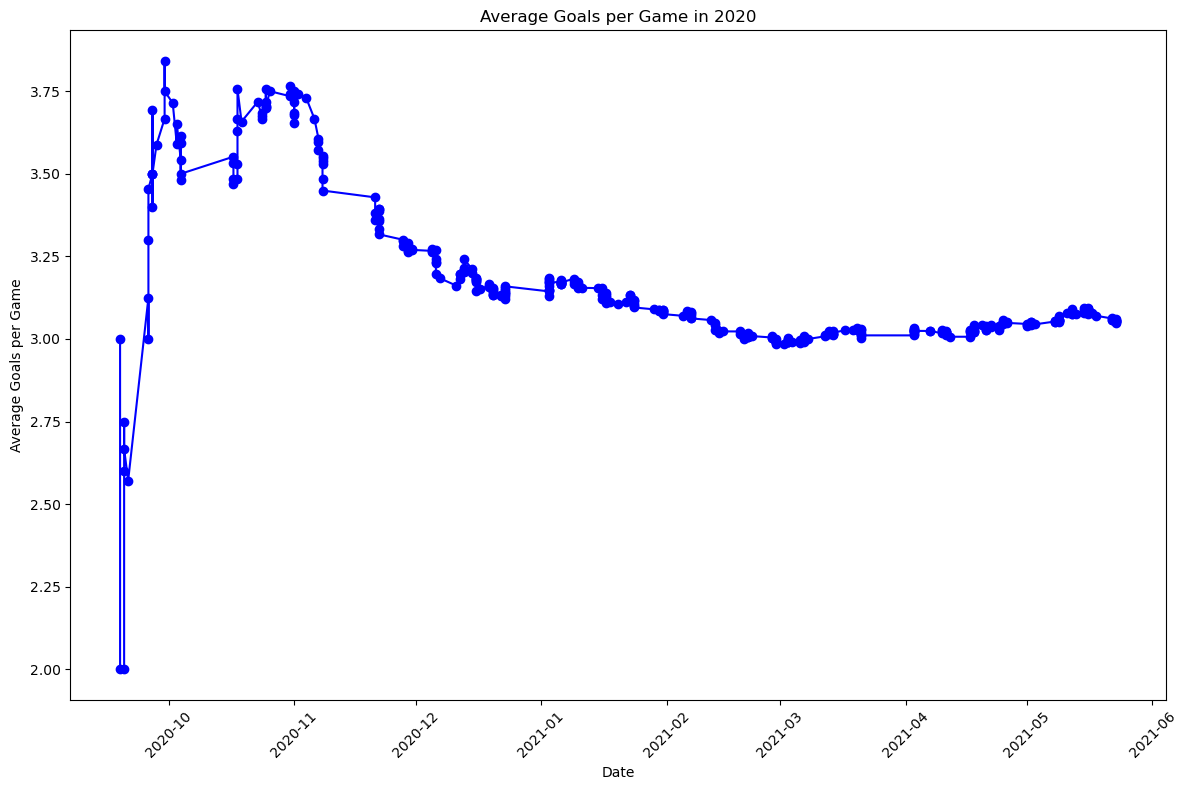

In [118]:
def plot_average_goals_per_game(competition_id, season):
    games_collection = mongo_db['games']

    pipeline = [
        {
            '$match': {
                'competition_id': competition_id,
                'season': season
            }
        },
        {
            '$project': {
                'date': 1,
                'total_goals': {'$add': ['$home_club_goals', '$away_club_goals']}
            }
        },
        {'$sort': {'date': 1}}
    ]

    df = pd.DataFrame(list(games_collection.aggregate(pipeline)))
    if not df.empty:
        # Calculate the cumulative sum of goals and the number of games
        df['cumulative_goals'] = df['total_goals'].cumsum()
        df['game_number'] = range(1, len(df) + 1)

        # Calculate the average goals per game
        df['average_goals_per_game'] = df['cumulative_goals'] / df['game_number']
    else:
        print("No data found for the specified competition and season.")
        return

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df['date'], df['average_goals_per_game'], marker='o', linestyle='-', color='b')
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Goals per Game')
    ax.set_title(f'Average Goals per Game in {season}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_average_goals_per_game(competition_id='IT1', season=2020)


# Attendance Statistics 

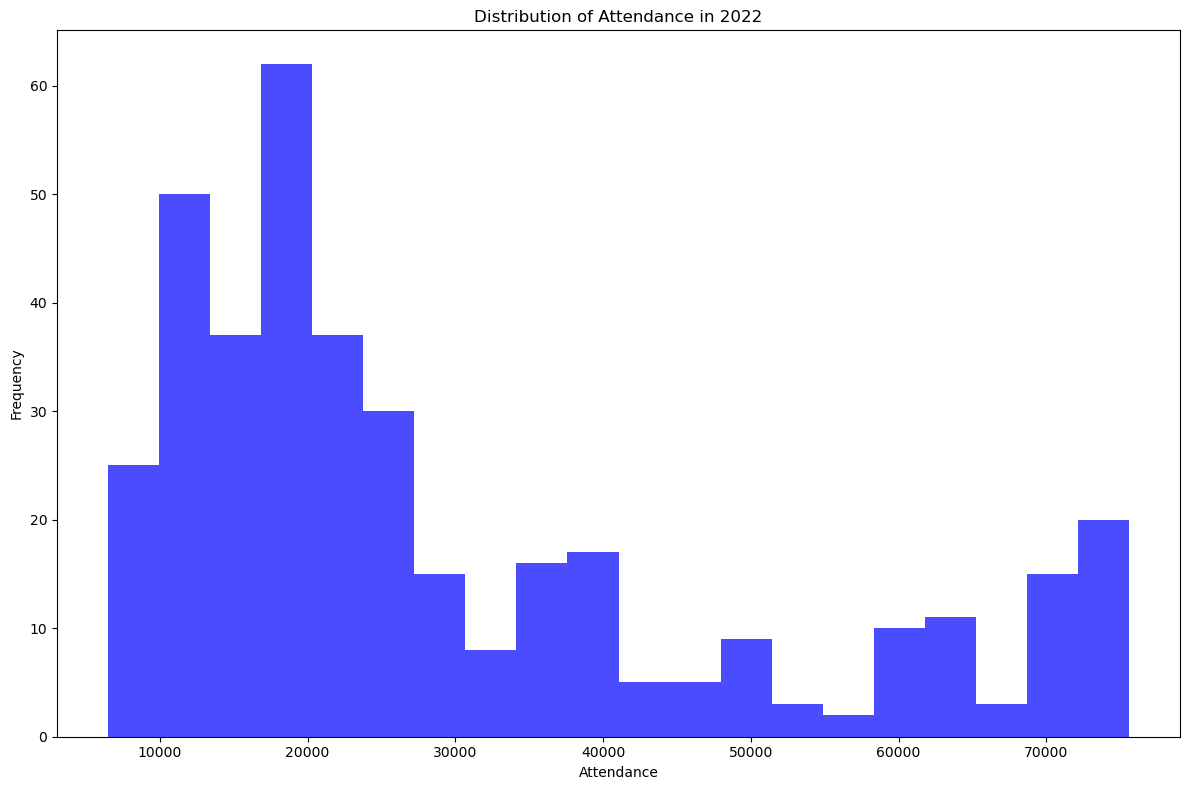

In [119]:
def plot_attendance_statistics(competition_id, season):
    games_collection = mongo_db['games']

    pipeline = [
        {
            '$match': {
                'competition_id': competition_id,
                'season': season
            }
        },
        {
            '$project': {
                'attendance': 1
            }
        }
    ]

    df = pd.DataFrame(list(games_collection.aggregate(pipeline)))
    if not df.empty:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.hist(df['attendance'], bins=20, color='b', alpha=0.7)
        ax.set_xlabel('Attendance')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of Attendance in {season}')
        plt.tight_layout()
        plt.show()
    else:
        print("No data found for the specified competition and season.")


plot_attendance_statistics(competition_id='IT1', season=2022)

# Display top assistman in a competition

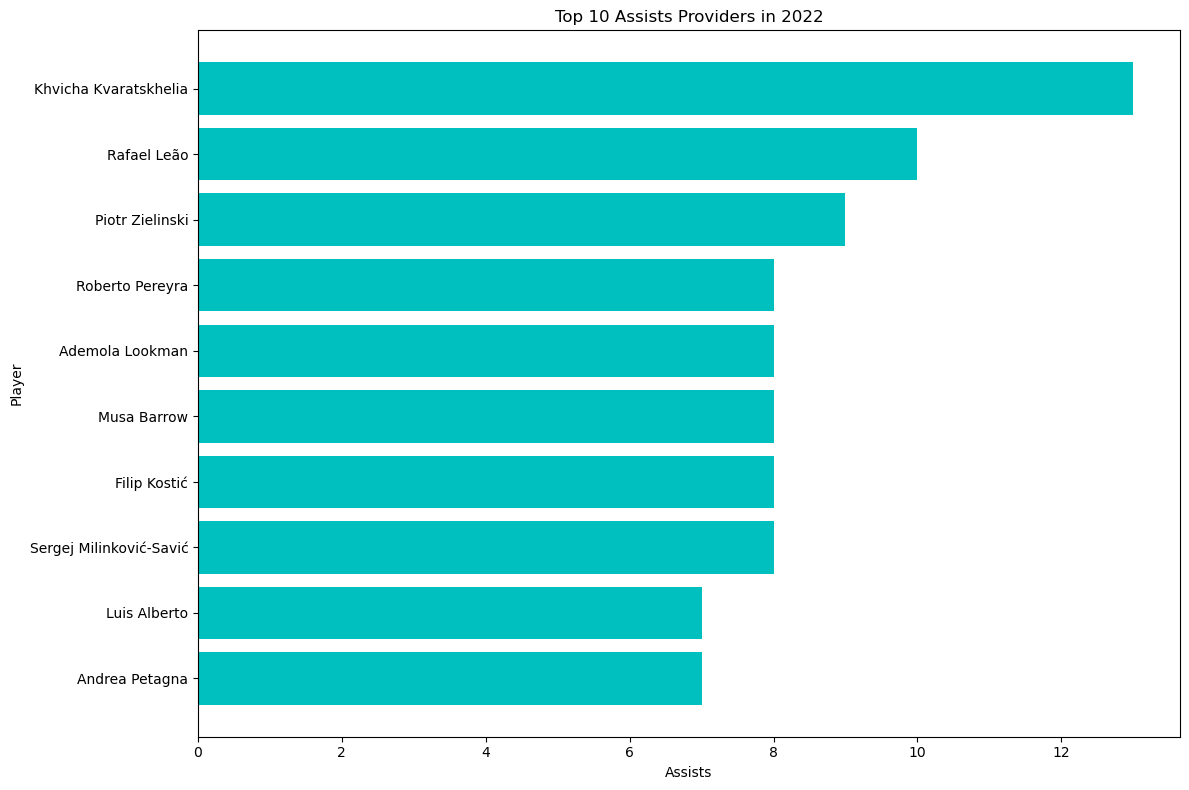

In [120]:
def plot_top_assists_providers(competition_id, season):
    top_n = 10
    appearances_collection = mongo_db['appearances']
    games_collection = mongo_db['games']

    game_ids = list(games_collection.find(
        {'competition_id': competition_id, 'season': season},
        {'game_id': 1, '_id': 0}
    ))
    game_ids = [game['game_id'] for game in game_ids]

    if not game_ids:
        print("No games found for the specified competition and season.")
        return

    pipeline = [
        {'$match': {'game_id': {'$in': game_ids}}},
        {'$group': {'_id': '$player_id', 'total_assists': {'$sum': '$assists'}}},
        {'$sort': {'total_assists': -1}},
        {'$limit': top_n}
    ]

    df = pd.DataFrame(list(appearances_collection.aggregate(pipeline)))

    if df.empty:
        print("No data found for the specified competition and season.")
        return

    df.rename(columns={'total_assists': 'assists'}, inplace=True)

    player_ids = df['_id'].tolist()
    pg_query = f"""
    SELECT player_id, name
    FROM players
    WHERE player_id IN ({','.join(map(str, player_ids))})
    """
    pg_df = pd.read_sql_query(pg_query, pg_engine)

    merged_df = df.merge(pg_df, how='left', left_on='_id', right_on='player_id')

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(merged_df['name'], merged_df['assists'], color='c')
    ax.set_xlabel('Assists')
    ax.set_ylabel('Player')
    ax.set_title(f'Top {top_n} Assists Providers in {season}')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


plot_top_assists_providers(competition_id='IT1', season=2022)


# Display domestic competition standings in a season

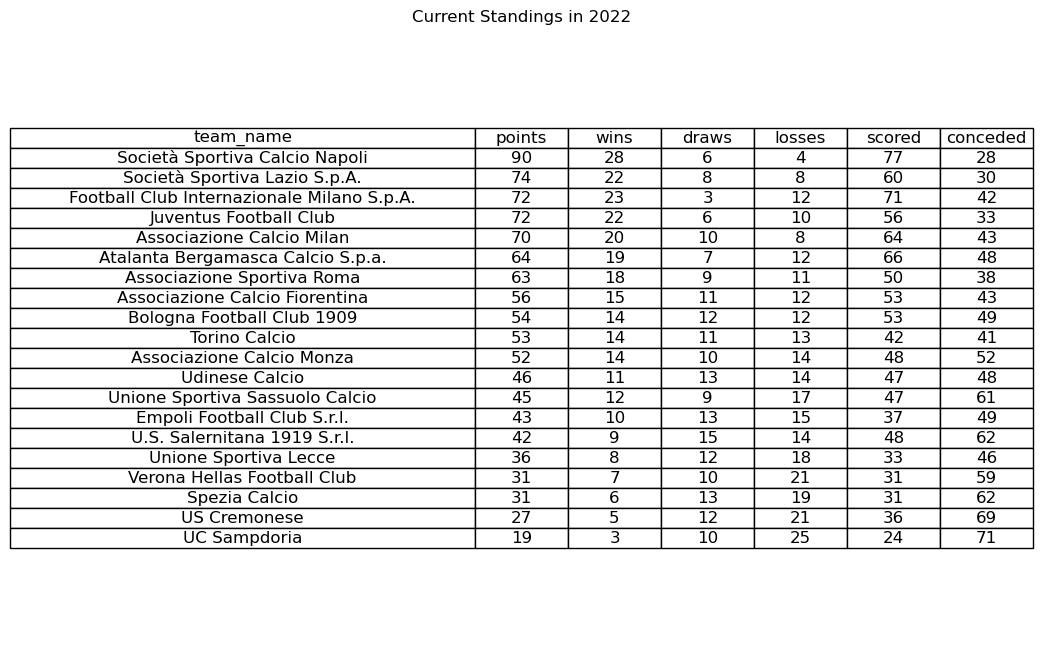

In [121]:
def plot_current_standings(competition_id, season):
    games_collection = mongo_db['games']

    mongo_pipeline = [
        {
            '$match': {
                'competition_id': competition_id,
                'season': season
            }
        },
        {
            '$facet': {
                'home_games': [
                    {
                        '$group': {
                            '_id': '$home_club_id',
                            'points': {
                                '$sum': {
                                    '$switch': {
                                        'branches': [
                                            {'case': {'$gt': ['$home_club_goals', '$away_club_goals']}, 'then': 3},
                                            {'case': {'$eq': ['$home_club_goals', '$away_club_goals']}, 'then': 1}
                                        ],
                                        'default': 0
                                    }
                                }
                            },
                            'wins': {'$sum': {'$cond': [{'$gt': ['$home_club_goals', '$away_club_goals']}, 1, 0]}},
                            'draws': {'$sum': {'$cond': [{'$eq': ['$home_club_goals', '$away_club_goals']}, 1, 0]}},
                            'losses': {'$sum': {'$cond': [{'$lt': ['$home_club_goals', '$away_club_goals']}, 1, 0]}},
                            'scored': {'$sum': '$home_club_goals'},
                            'conceded': {'$sum': '$away_club_goals'}
                        }
                    }
                ],
                'away_games': [
                    {
                        '$group': {
                            '_id': '$away_club_id',
                            'points': {
                                '$sum': {
                                    '$switch': {
                                        'branches': [
                                            {'case': {'$gt': ['$away_club_goals', '$home_club_goals']}, 'then': 3},
                                            {'case': {'$eq': ['$away_club_goals', '$home_club_goals']}, 'then': 1}
                                        ],
                                        'default': 0
                                    }
                                }
                            },
                            'wins': {'$sum': {'$cond': [{'$gt': ['$away_club_goals', '$home_club_goals']}, 1, 0]}},
                            'draws': {'$sum': {'$cond': [{'$eq': ['$away_club_goals', '$home_club_goals']}, 1, 0]}},
                            'losses': {'$sum': {'$cond': [{'$lt': ['$away_club_goals', '$home_club_goals']}, 1, 0]}},
                            'scored': {'$sum': '$away_club_goals'},
                            'conceded': {'$sum': '$home_club_goals'}
                        }
                    }
                ]
            }
        },
        {
            '$project': {
                'standings': {
                    '$setUnion': ['$home_games', '$away_games']
                }
            }
        },
        {
            '$unwind': '$standings'
        },
        {
            '$group': {
                '_id': '$standings._id',
                'points': {'$sum': '$standings.points'},
                'wins': {'$sum': '$standings.wins'},
                'draws': {'$sum': '$standings.draws'},
                'losses': {'$sum': '$standings.losses'},
                'scored': {'$sum': '$standings.scored'},
                'conceded': {'$sum': '$standings.conceded'}
            }
        }
    ]

    mongo_df = pd.DataFrame(list(games_collection.aggregate(mongo_pipeline)))

    if mongo_df.empty:
        print("No data found for the specified competition and season in MongoDB.")
        return

    #  query to fetch club names
    club_ids = tuple(mongo_df['_id'].tolist())
    pg_query = f"""
    SELECT club_id, name
    FROM clubs
    WHERE club_id IN {club_ids}
    """

    # Execute  query
    pg_df = pd.read_sql_query(pg_query, pg_engine)

    if pg_df.empty:
        print("No data found for the specified competition and season in PostgreSQL.")
        return

    # Merge MongoDB and PostgreSQL data
    merged_df = mongo_df.merge(pg_df, how='left', left_on='_id', right_on='club_id')
    merged_df.drop(['_id', 'club_id'], axis=1, inplace=True)
    merged_df.rename(columns={'name': 'team_name'}, inplace=True)
    merged_df.fillna(0, inplace=True)

    columns = ['team_name', 'points', 'wins', 'draws', 'losses', 'scored', 'conceded']
    merged_df = merged_df[columns]

    # Sorting the standings
    merged_df.sort_values(by=['points', 'scored', 'conceded'], ascending=[False, False, True], inplace=True)

    # Plotting the standings
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=merged_df.values, colLabels=merged_df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)

    #i had to do this, because the team names were too long
    #and could not be contained in the whole cell

    team_name_col_width = 0.5
    for key, cell in table.get_celld().items():
        if key[1] == 0:  # 0 is the index of the 'team_name' column
            cell.set_width(team_name_col_width)
        else:
            cell.set_width(0.1)  # making the other colummns to be smaller

    plt.title(f'Current Standings in {season}')
    plt.show()


plot_current_standings(competition_id='IT1', season=2022)

 # Display  home vs away goals conceded

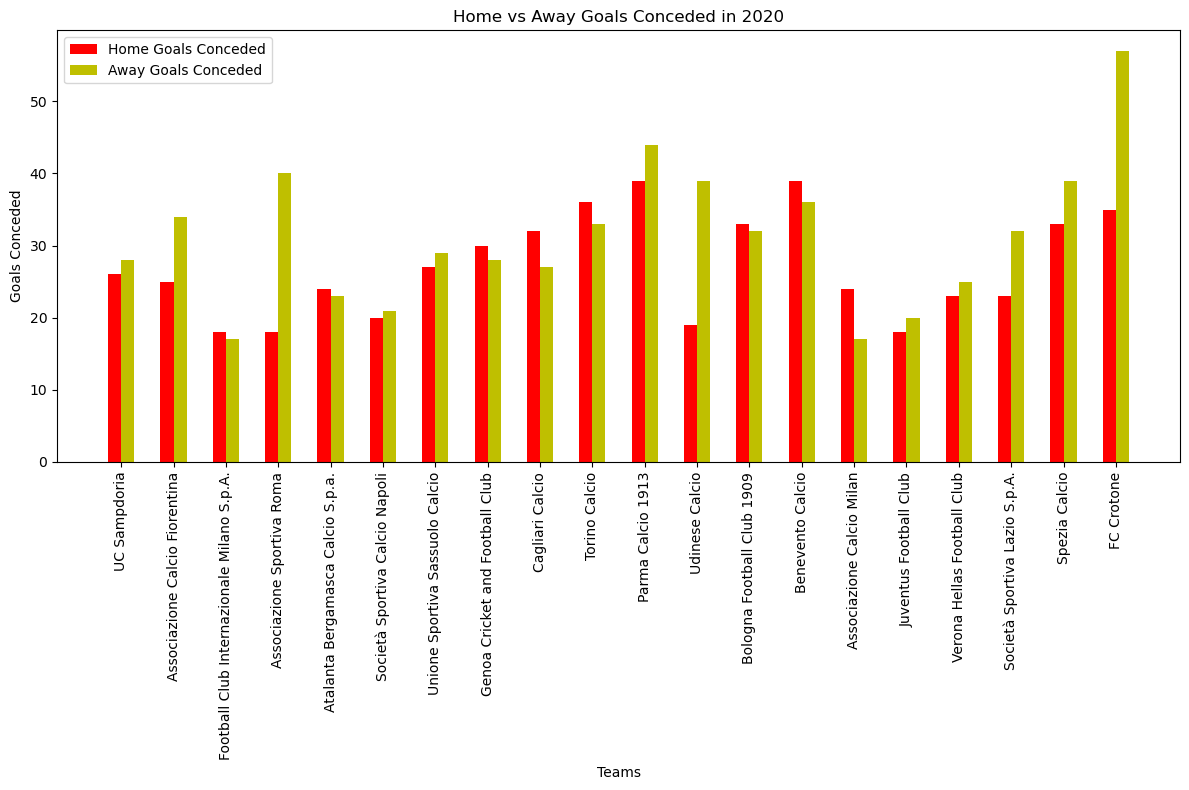

In [122]:
def plot_home_vs_away_goals_conceded(competition_id, season):
    games_collection = mongo_db['games']

    mongo_pipeline = [
        {
            '$match': {
                'competition_id': competition_id,
                'season': season
            }
        },
        {
            '$facet': {
                'home_games': [
                    {
                        '$group': {
                            '_id': '$home_club_id',
                            'home_goals_conceded': {'$sum': '$away_club_goals'}
                        }
                    }
                ],
                'away_games': [
                    {
                        '$group': {
                            '_id': '$away_club_id',
                            'away_goals_conceded': {'$sum': '$home_club_goals'}
                        }
                    }
                ]
            }
        },
        {
            '$project': {
                'standings': {
                    '$setUnion': ['$home_games', '$away_games']
                }
            }
        },
        {
            '$unwind': '$standings'
        },
        {
            '$group': {
                '_id': '$standings._id',
                'home_goals_conceded': {'$sum': '$standings.home_goals_conceded'},
                'away_goals_conceded': {'$sum': '$standings.away_goals_conceded'}
            }
        }
    ]

    mongo_df = pd.DataFrame(list(games_collection.aggregate(mongo_pipeline)))

    if mongo_df.empty:
        print("No data found for the specified competition and season in MongoDB.")
        return

    #  query to fetch club names
    club_ids = tuple(mongo_df['_id'].tolist())
    pg_query = f"""
    SELECT club_id, name
    FROM clubs
    WHERE club_id IN {club_ids}
    """

    # Execute  query
    pg_df = pd.read_sql_query(pg_query, pg_engine)

    if pg_df.empty:
        print("No data found for the specified competition and season in PostgreSQL.")
        return

    merged_df = mongo_df.merge(pg_df, how='left', left_on='_id', right_on='club_id')
    merged_df.drop(['_id', 'club_id'], axis=1, inplace=True)
    merged_df.rename(columns={'name': 'team_name'}, inplace=True)
    merged_df.fillna(0, inplace=True)

    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.25
    index = range(len(merged_df))

    bar1 = ax.bar(index, merged_df['home_goals_conceded'], bar_width, color='r', label='Home Goals Conceded')
    bar2 = ax.bar([i + bar_width for i in index], merged_df['away_goals_conceded'], bar_width, color='y',
                  label='Away Goals Conceded')

    ax.set_xlabel('Teams')
    ax.set_ylabel('Goals Conceded')
    ax.set_title(f'Home vs Away Goals Conceded in {season}')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(merged_df['team_name'], rotation=90)

    ax.legend()

    plt.tight_layout()
    plt.show()


plot_home_vs_away_goals_conceded(competition_id='IT1', season=2020)


# Display Home  vs Away goals conceded

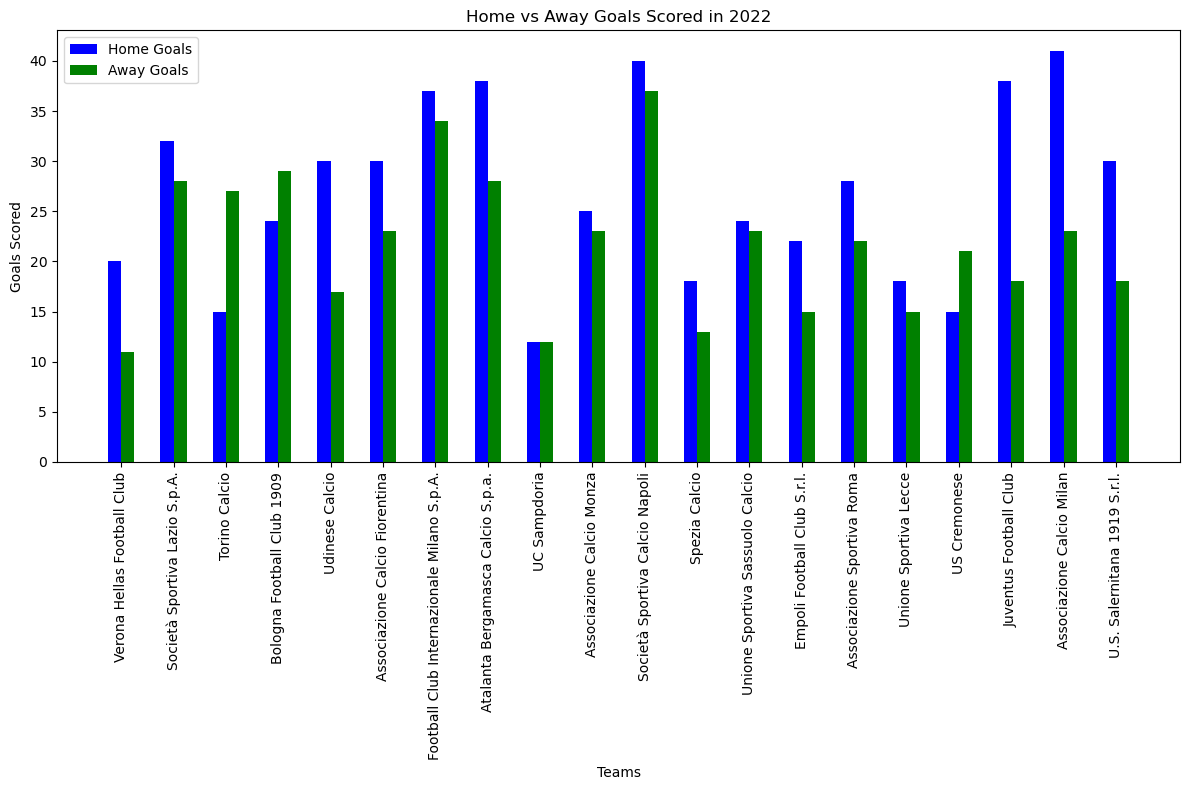

In [123]:
def plot_home_vs_away_goals_scored(competition_id, season):
    games_collection = mongo_db['games']

    mongo_pipeline = [
        {
            '$match': {
                'competition_id': competition_id,
                'season': season
            }
        },
        {
            '$facet': {
                'home_games': [
                    {
                        '$group': {
                            '_id': '$home_club_id',
                            'home_goals': {'$sum': '$home_club_goals'}
                        }
                    }
                ],
                'away_games': [
                    {
                        '$group': {
                            '_id': '$away_club_id',
                            'away_goals': {'$sum': '$away_club_goals'}
                        }
                    }
                ]
            }
        },
        {
            '$project': {
                'standings': {
                    '$setUnion': ['$home_games', '$away_games']
                }
            }
        },
        {
            '$unwind': '$standings'
        },
        {
            '$group': {
                '_id': '$standings._id',
                'home_goals': {'$sum': '$standings.home_goals'},
                'away_goals': {'$sum': '$standings.away_goals'}
            }
        }
    ]

    mongo_df = pd.DataFrame(list(games_collection.aggregate(mongo_pipeline)))

    if mongo_df.empty:
        print("No data found for the specified competition and season in MongoDB.")
        return

    #  query to fetch club names
    club_ids = tuple(mongo_df['_id'].tolist())
    pg_query = f"""
    SELECT club_id, name
    FROM clubs
    WHERE club_id IN {club_ids}
    """

    # Execute  query
    pg_df = pd.read_sql_query(pg_query, pg_engine)

    if pg_df.empty:
        print("No data found for the specified competition and season in PostgreSQL.")
        return

    # Merge MongoDB and Postgre data
    merged_df = mongo_df.merge(pg_df, how='left', left_on='_id', right_on='club_id')
    merged_df.drop(['_id', 'club_id'], axis=1, inplace=True)
    merged_df.rename(columns={'name': 'team_name'}, inplace=True)
    merged_df.fillna(0, inplace=True)

    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.25
    index = range(len(merged_df))

    bar1 = ax.bar(index, merged_df['home_goals'], bar_width, color='b', label='Home Goals')
    bar2 = ax.bar([i + bar_width for i in index], merged_df['away_goals'], bar_width, color='g', label='Away Goals')

    ax.set_xlabel('Teams')
    ax.set_ylabel('Goals Scored')
    ax.set_title(f'Home vs Away Goals Scored in {season}')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(merged_df['team_name'], rotation=90)

    ax.legend()

    plt.tight_layout()
    plt.show()


plot_home_vs_away_goals_scored(competition_id='IT1', season=2022)


# Distribution of the games outcome

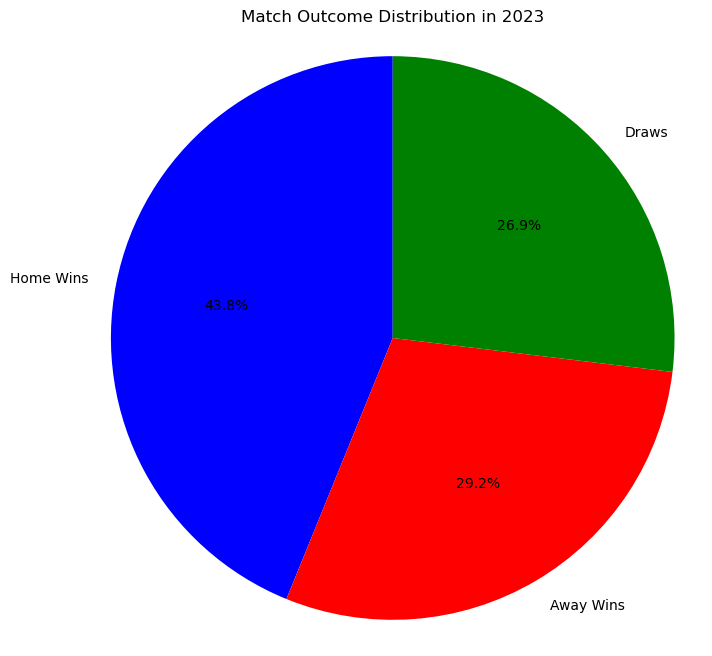

In [124]:
def plot_match_outcome_distribution(competition_id, season):
    games_collection = mongo_db['games']

    pipeline = [
        {
            '$match': {
                'competition_id': competition_id,
                'season': season
            }
        },
        {
            '$group': {
                '_id': None,
                'home_wins': {
                    '$sum': {'$cond': [{'$gt': ['$home_club_goals', '$away_club_goals']}, 1, 0]}
                },
                'away_wins': {
                    '$sum': {'$cond': [{'$lt': ['$home_club_goals', '$away_club_goals']}, 1, 0]}
                },
                'draws': {
                    '$sum': {'$cond': [{'$eq': ['$home_club_goals', '$away_club_goals']}, 1, 0]}
                }
            }
        }
    ]

    outcome_data = list(games_collection.aggregate(pipeline))

    if outcome_data:
        outcome = outcome_data[0]
        labels = ['Home Wins', 'Away Wins', 'Draws']
        sizes = [outcome['home_wins'], outcome['away_wins'], outcome['draws']]

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'red', 'green'])
        ax.axis('equal')  # this is done to make sure that the chart looks like a circle
        plt.title(f'Match Outcome Distribution in {season}')
        plt.show()
    else:
        print("No data found for the given competition and season.")


plot_match_outcome_distribution(competition_id='IT1', season=2023)


# Monthly goal scoring trends

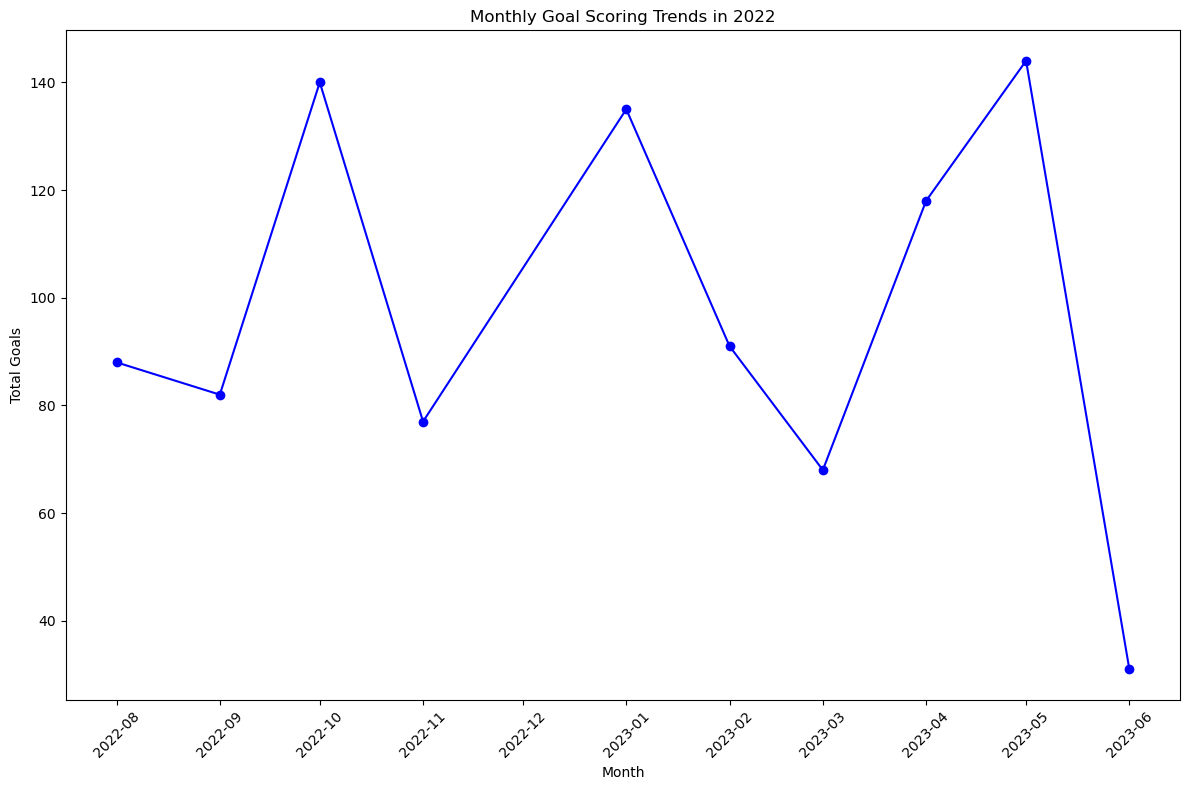

In [125]:
def plot_monthly_goal_scoring_trends(competition_id, season):
    games_collection = mongo_db['games']

    pipeline = [
        {
            '$match': {
                'competition_id': competition_id,
                'season': season
            }
        },
        {
            '$group': {
                '_id': {
                    '$dateToString': {'format': '%Y-%m', 'date': '$date'}
                },
                'total_goals': {
                    '$sum': {'$add': ['$home_club_goals', '$away_club_goals']}
                }
            }
        },
        {
            '$sort': {'_id': 1}
        }
    ]

    monthly_goals = list(games_collection.aggregate(pipeline))

    if monthly_goals:
        df = pd.DataFrame(monthly_goals)
        if '_id' in df.columns:
            df.rename(columns={'_id': 'month'}, inplace=True)
        else:
            print("Error: The expected 'month' field is missing from the MongoDB aggregation result.")
            return

        df['month'] = pd.to_datetime(df['month'])

        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(df['month'], df['total_goals'], marker='o', linestyle='-', color='b')
        ax.set_xlabel('Month')
        ax.set_ylabel('Total Goals')
        ax.set_title(f'Monthly Goal Scoring Trends in {season}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No data found for the given competition and season.")


plot_monthly_goal_scoring_trends(competition_id='IT1', season=2022)


# Goals by time interval

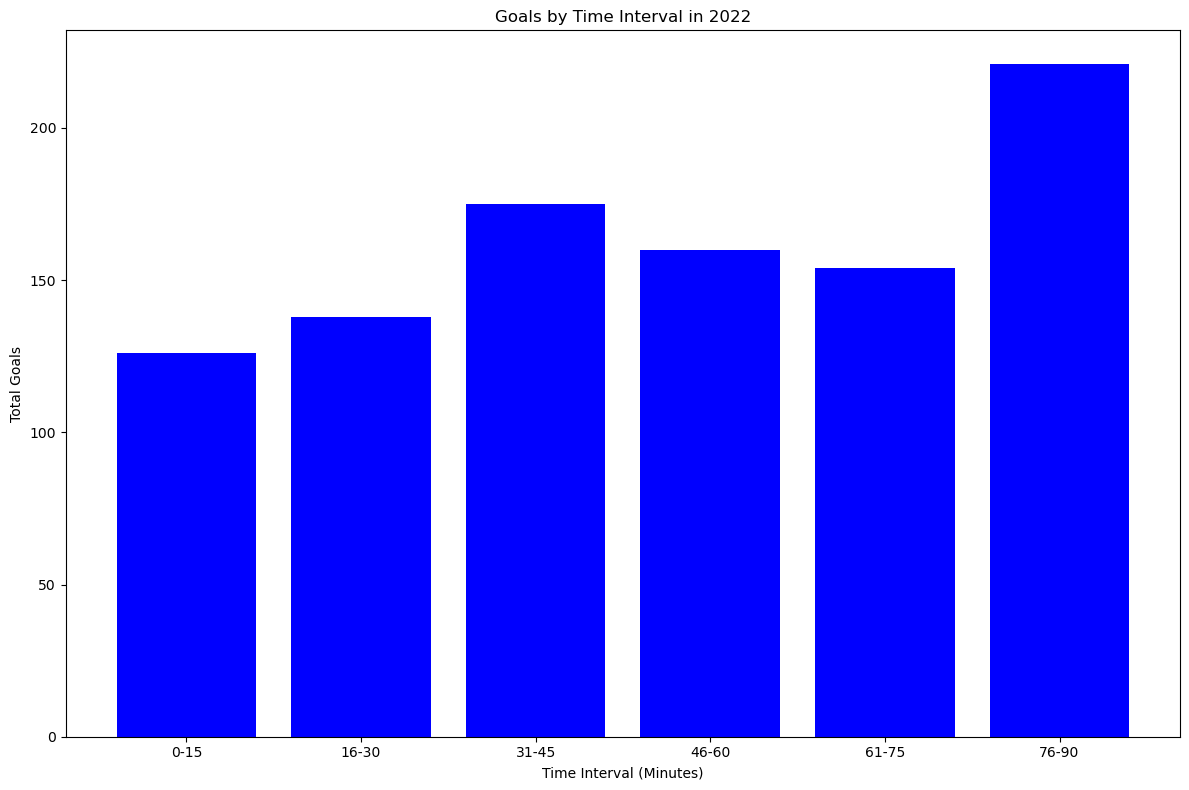

In [126]:

def plot_goals_by_time_interval(competition_id, season):
    
    pipeline = [
        {
            "$lookup": {
                "from": "games",
                "localField": "game_id",
                "foreignField": "game_id",
                "as": "game_info"
            }
        },
        {
            "$unwind": "$game_info"
        },
        {
            "$match": {
                "game_info.competition_id": competition_id,
                "game_info.season": season,
                "type": "Goals"
            }
        },
        {
            "$group": {
                "_id": None,
                "0-15": {"$sum": {"$cond": [{"$and": [{"$gte": ["$minute", 0]}, {"$lte": ["$minute", 15]}]}, 1, 0]}},
                "16-30": {"$sum": {"$cond": [{"$and": [{"$gte": ["$minute", 16]}, {"$lte": ["$minute", 30]}]}, 1, 0]}},
                "31-45": {"$sum": {"$cond": [{"$and": [{"$gte": ["$minute", 31]}, {"$lte": ["$minute", 45]}]}, 1, 0]}},
                "46-60": {"$sum": {"$cond": [{"$and": [{"$gte": ["$minute", 46]}, {"$lte": ["$minute", 60]}]}, 1, 0]}},
                "61-75": {"$sum": {"$cond": [{"$and": [{"$gte": ["$minute", 61]}, {"$lte": ["$minute", 75]}]}, 1, 0]}},
                "76-90": {"$sum": {"$cond": [{"$and": [{"$gte": ["$minute", 76]}, {"$lte": ["$minute", 90]}]}, 1, 0]}}
            }
        }
    ]

    result = list(mongo_db.gameevents.aggregate(pipeline))
    if result:
        df = pd.DataFrame(result)
        df = df.fillna(0)  

        intervals = df.columns[1:]  # not the _id column
        goals = df.iloc[0, 1:].tolist()  

        fig, ax = plt.subplots(figsize=(12, 8))
        ax.bar(intervals, goals, color='b')
        ax.set_xlabel('Time Interval (Minutes)')
        ax.set_ylabel('Total Goals')
        ax.set_title(f'Goals by Time Interval in {season}')
        plt.tight_layout()
        plt.show()
    else:
        print("No data found for the given competition_id and season.")

plot_goals_by_time_interval(competition_id='IT1', season=2022)

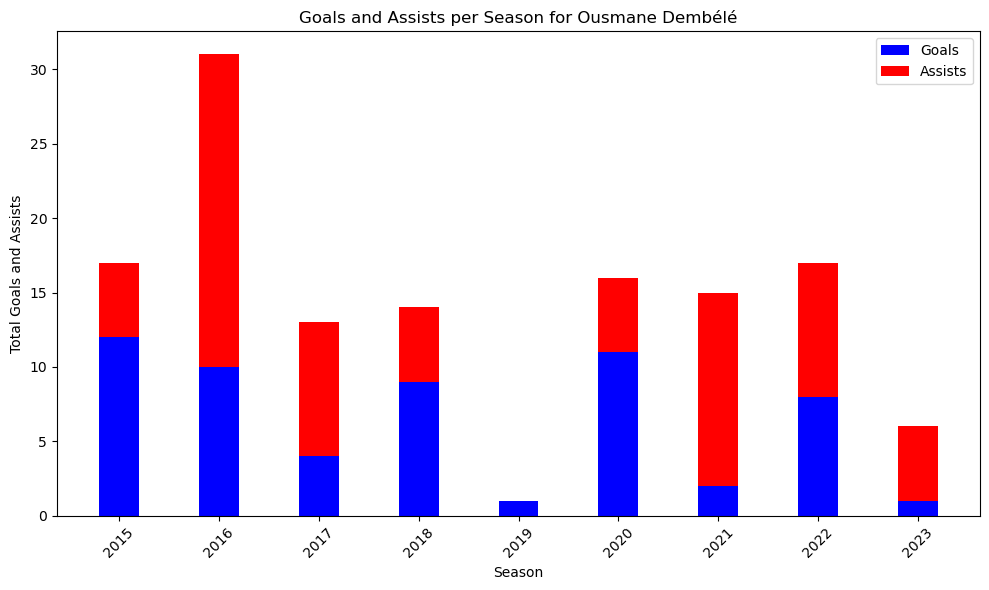

MongoDB Aggregation Result: [{'_id': 2015, 'total_minutes': 1941}, {'_id': 2016, 'total_minutes': 3388}, {'_id': 2017, 'total_minutes': 1220}, {'_id': 2018, 'total_minutes': 1809}, {'_id': 2019, 'total_minutes': 494}, {'_id': 2020, 'total_minutes': 2703}, {'_id': 2021, 'total_minutes': 1946}, {'_id': 2022, 'total_minutes': 2028}, {'_id': 2023, 'total_minutes': 1354}]


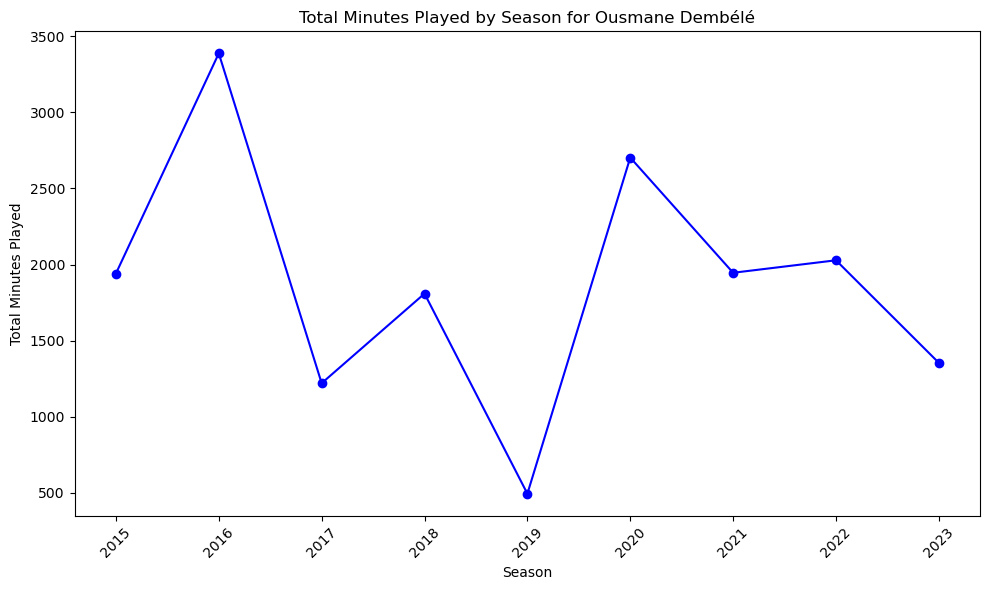

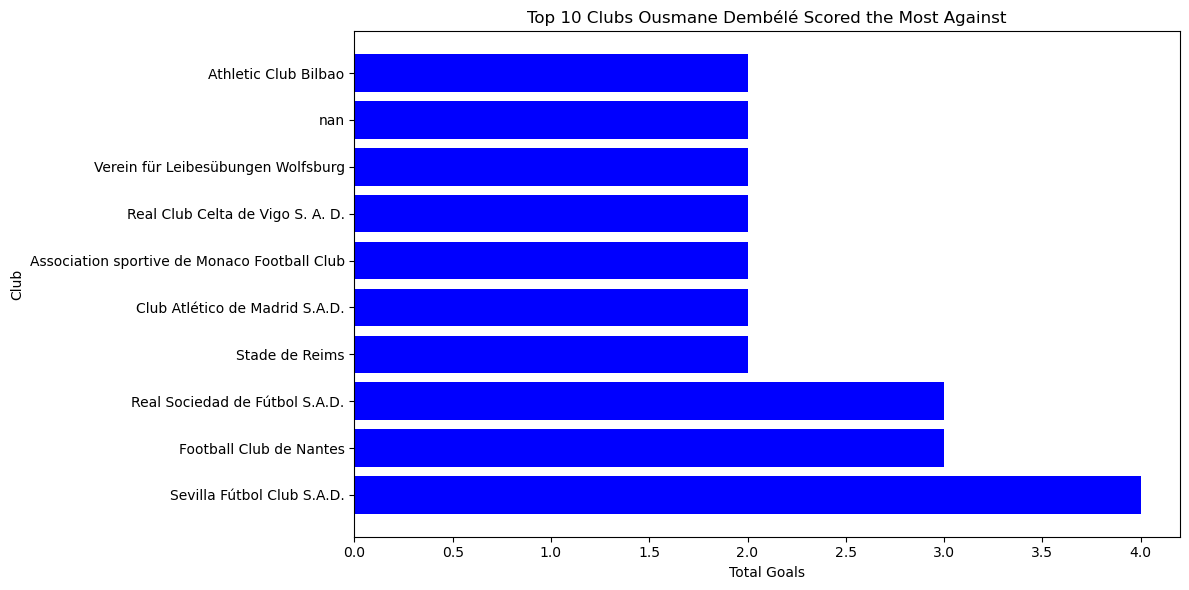

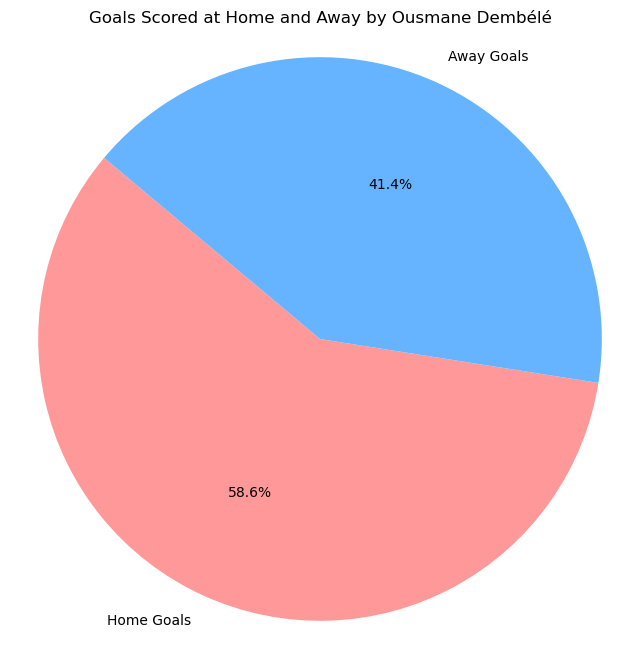

In [127]:
plot_goals_assists_per_season(player_id=288230)
plot_minutes_played_by_season(player_id=288230, season_start=2012, season_end=2023)
plot_goals_against_top_clubs(player_id=288230)
plot_home_away_goals(player_id=288230)